## Training for H1 rapgap MC with reconstructed observables as input.
### This version trains a classification network to attempt to identify events with ISR or FSR which is then fed into the regression network.


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3

import matplotlib as mpl

from datetime import datetime
import subprocess


In [2]:
#has_gpu = False

has_gpu = True

training_name = 'training_h1_classification_vDB'




#--- Hyperparameter settings.

#max_events =   120000
#max_events =   600000
#max_events =  3000000
#max_events = 15000000
max_events = 1e9


learning_rate_setval_cat = 1e-4  ########
learning_rate_setval_reg = 1e-5  ########
batch_size_setval = 128
max_epochs = 5000
dropout_setval = 0.0




#input_file = 'h1-fullsim/all-h1-rapgap.root'
#input_file = '/dev/shm/all-h1-rapgap.root'
input_file = '/dev/shm/rapgap.root'

parfile = open( '%s-setup.txt' % training_name,'w')

parfile.write('%s\n' % datetime.now() )
parfile.write('training_name : %s\n' % training_name )
parfile.write('input_file : %s\n' % input_file )
parfile.write('max_events : %d\n' % max_events )
parfile.write('learning_rate_setval_cat : %g\n' % learning_rate_setval_cat )
parfile.write('learning_rate_setval_reg : %g\n' % learning_rate_setval_reg )
parfile.write('batch_size_setval : %d\n' % batch_size_setval )
parfile.write('max_epochs : %d\n' % max_epochs )
parfile.write('dropout_setval : %g\n' % dropout_setval )

parfile.close()

print('\n\n--- Training parameters file: %s-setup.txt\n' % training_name )
print( subprocess.getoutput('cat %s-setup.txt' % training_name ) )
print('\n\n')
    




--- Training parameters file: training_h1_classification_vDB-setup.txt

2021-09-26 17:32:25.766481
training_name : training_h1_classification_vDB
input_file : /dev/shm/rapgap.root
max_events : 1000000000
learning_rate_setval_cat : 0.0001
learning_rate_setval_reg : 1e-05
batch_size_setval : 128
max_epochs : 5000
dropout_setval : 0





In [3]:
%%time


ur_file = uproot3.open(input_file)

print (ur_file.keys()) 
ur_tree = ur_file['Rapgap/minitree']
print(ur_tree)
ur_tree.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df   =  ur_tree.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', 
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
     'Empz', 'obs_e_trk_e',
     'gen_new_Qi2s', 'gen_new_xis','gen_new_yis',
     'gen_new_Q2ida','gen_new_xida', 'gen_new_yida',
     'gen_eBare_pt', 'gen_eDressed_pt',
     'gen_HFS_Sigma','gen_HFS_T','gen_HFS_tangam',
     'gen_eBare_Sig_e','gen_eBare_tanthe',  
     'beam_e_e'
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )

[b'Rapgap;1']
<TTree b'minitree' at 0x7fa070354700>
wgt                        (no streamer)              asdtype('>f4')
Empz                       (no streamer)              asdtype('>f4')
from_tlv_gen_Q2            (no streamer)              asdtype('>f4')
from_tlv_gen_x             (no streamer)              asdtype('>f4')
from_tlv_gen_y             (no streamer)              asdtype('>f4')
gen_new_Qi2s               (no streamer)              asdtype('>f4')
gen_new_xis                (no streamer)              asdtype('>f4')
gen_new_yis                (no streamer)              asdtype('>f4')
gen_new_Q2ida              (no streamer)              asdtype('>f4')
gen_new_xida               (no streamer)              asdtype('>f4')
gen_new_yida               (no streamer)              asdtype('>f4')
gen_eBare_pt               (no streamer)              asdtype('>f4')
gen_eDressed_pt            (no streamer)              asdtype('>f4')
gen_HFS_Sigma              (no streamer)           

In [4]:
pandas_df

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,gen_new_xida,gen_new_yida,gen_eBare_pt,gen_eDressed_pt,gen_HFS_Sigma,gen_HFS_T,gen_HFS_tangam,gen_eBare_Sig_e,gen_eBare_tanthe,beam_e_e
entry,,,,,,,,,,,,,,,,,,,,,
0,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.075583,0.008423,6.002093,6.002093,0.260681,5.989288,0.043525,30.753227,5.123750,27.6
1,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010258,0.446215,11.130349,11.130348,12.046692,11.313186,1.064836,14.709190,1.321539,27.6
2,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.012595,0.053352,8.014763,8.014763,2.928101,8.014862,0.365334,51.953850,6.482269,27.6
3,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002430,0.595516,2.016139,2.016139,2.860535,2.565612,1.114952,1.526808,0.757293,27.6
4,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.013847,0.382458,18.225758,18.225758,21.111877,18.225756,1.158354,34.088577,1.870352,27.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61636816,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001714,0.675458,6.178102,6.178102,37.285583,6.178102,6.035120,17.914839,2.899732,27.6
61636817,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001553,0.459438,6.258390,6.258390,25.361206,6.258389,4.052354,29.839291,4.767886,27.6
61636818,0,1,24.007572,1,-0.637264,2.351282,1.337233,0.012592,0.013100,0.012119,...,0.010643,0.256855,13.675396,14.364692,14.177917,14.363246,0.987097,38.893890,2.844078,27.6


In [5]:
pandas_df.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [8]:
pandas_df.eval( 'gen_ptbal = 1. - gen_eBare_pt/gen_HFS_T', inplace=True )
pandas_df.eval( 'gen_pzbal = 1. - (gen_eBare_Sig_e + gen_HFS_Sigma)/2./beam_e_e', inplace=True )
pandas_df.eval( 'gen_anbal = 1. - gen_eBare_Sig_e / gen_HFS_Sigma * gen_HFS_tangam / gen_eBare_tanthe', inplace=True )

pandas_df.eval( 'gen_empz = gen_eBare_Sig_e + gen_HFS_Sigma', inplace=True )

pandas_df.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )



In [9]:
pandas_df

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,gen_ptbal,gen_pzbal,gen_anbal,obs_ptbal,obs_pzbal,gen_empz
entry,,,,,,,,,,,,,,,,,,,,,
0,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.588407,NaN,-1.000000,False,-2.137899e-03,0.438154,-2.138019e-03,NaN,1.000000,31.013908
1,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.435722,NaN,-1.000000,False,1.616138e-02,0.515292,1.616144e-02,NaN,1.000000,26.755882
2,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.217414,NaN,-1.000000,False,1.239777e-05,0.005762,1.245737e-05,NaN,1.000000,54.881950
3,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.654275,NaN,-1.000000,False,2.141685e-01,0.920519,2.141685e-01,NaN,1.000000,4.387343
4,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.287672,NaN,-1.000000,True,-1.192093e-07,-0.000008,-1.192093e-07,NaN,1.000000,55.200455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61636816,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.767356,NaN,-1.000000,True,0.000000e+00,-0.000008,5.960464e-08,NaN,1.000000,55.200424
61636817,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.282982,NaN,-1.000000,True,-3.576279e-07,-0.000009,-2.384186e-07,NaN,1.000000,55.200497
61636818,0,1,24.007572,1,-0.637264,2.351282,1.337233,0.012592,0.013100,0.012119,...,5.626319,1.114325,3.086085,False,4.788959e-02,0.038554,4.788953e-02,-0.132641,-0.006741,53.071808


## Apply any event selection here.

In [13]:
pandas_df = pandas_df.query('Empz > 0')

pandas_df = pandas_df.query('obs_event_Empz > 46 and obs_event_Empz < 62')
pandas_df = pandas_df.query('gen_empz > 44 and gen_empz < 64')

pandas_df = pandas_df.query('obs_hfs_pt > 0')

pandas_df = pandas_df.query('from_tlv_gen_Q2 > 200')

pandas_df = pandas_df.query('e_ecal_over_trk_ratio > 0')

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )



 Number of entries in pandas_df:  12030185 


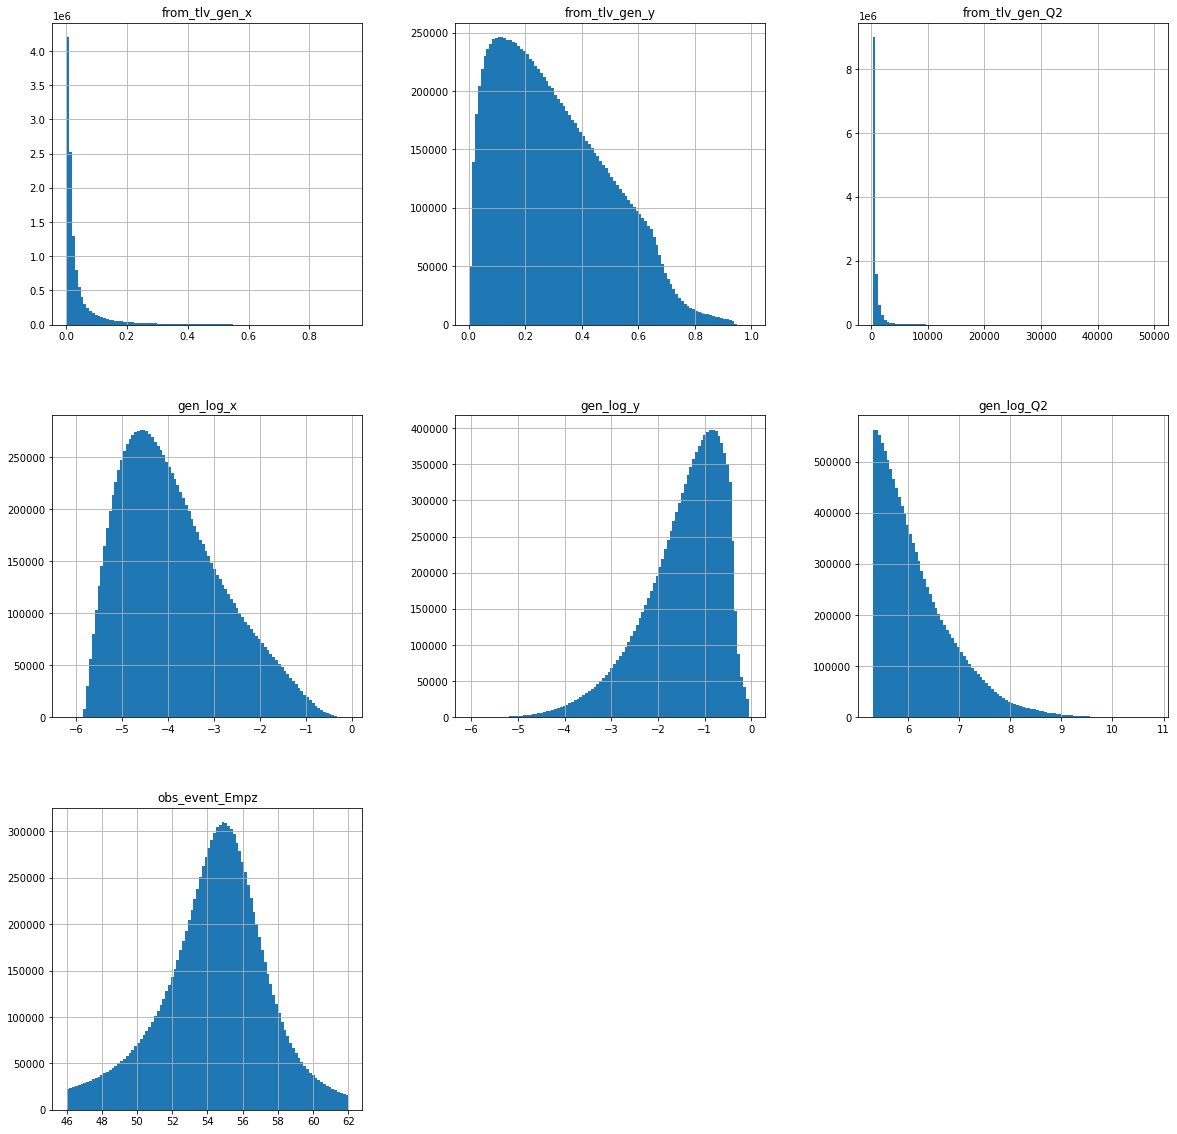

In [14]:
pandas_df.hist( figsize=(20,20), bins=100, column=['from_tlv_gen_x','from_tlv_gen_y','from_tlv_gen_Q2',
                        'gen_log_x','gen_log_y','gen_log_Q2','obs_event_Empz', 
                        ])
plt.show()

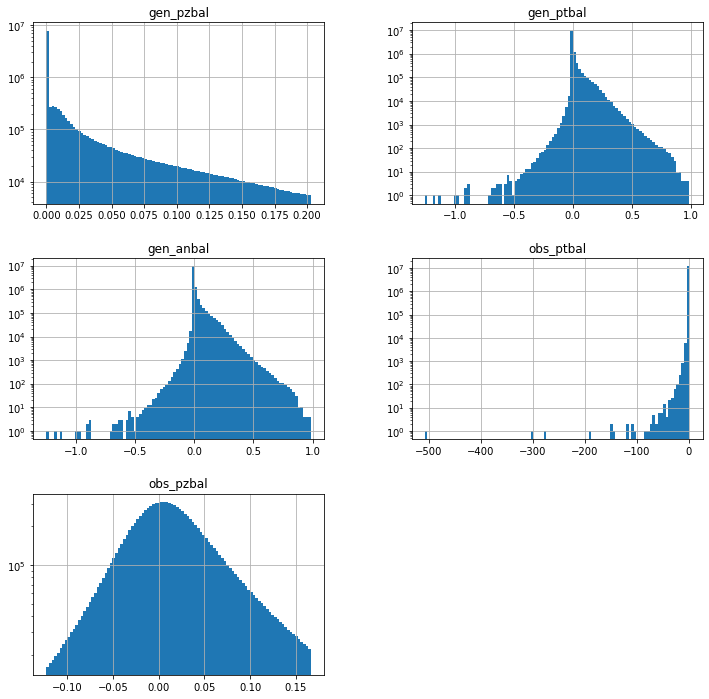

In [15]:
pandas_df.hist( figsize=(12,12), bins=100, column=[
                        'gen_pzbal','gen_ptbal','gen_anbal',
                        'obs_ptbal','obs_pzbal'
                        ], log=True)
plt.show()

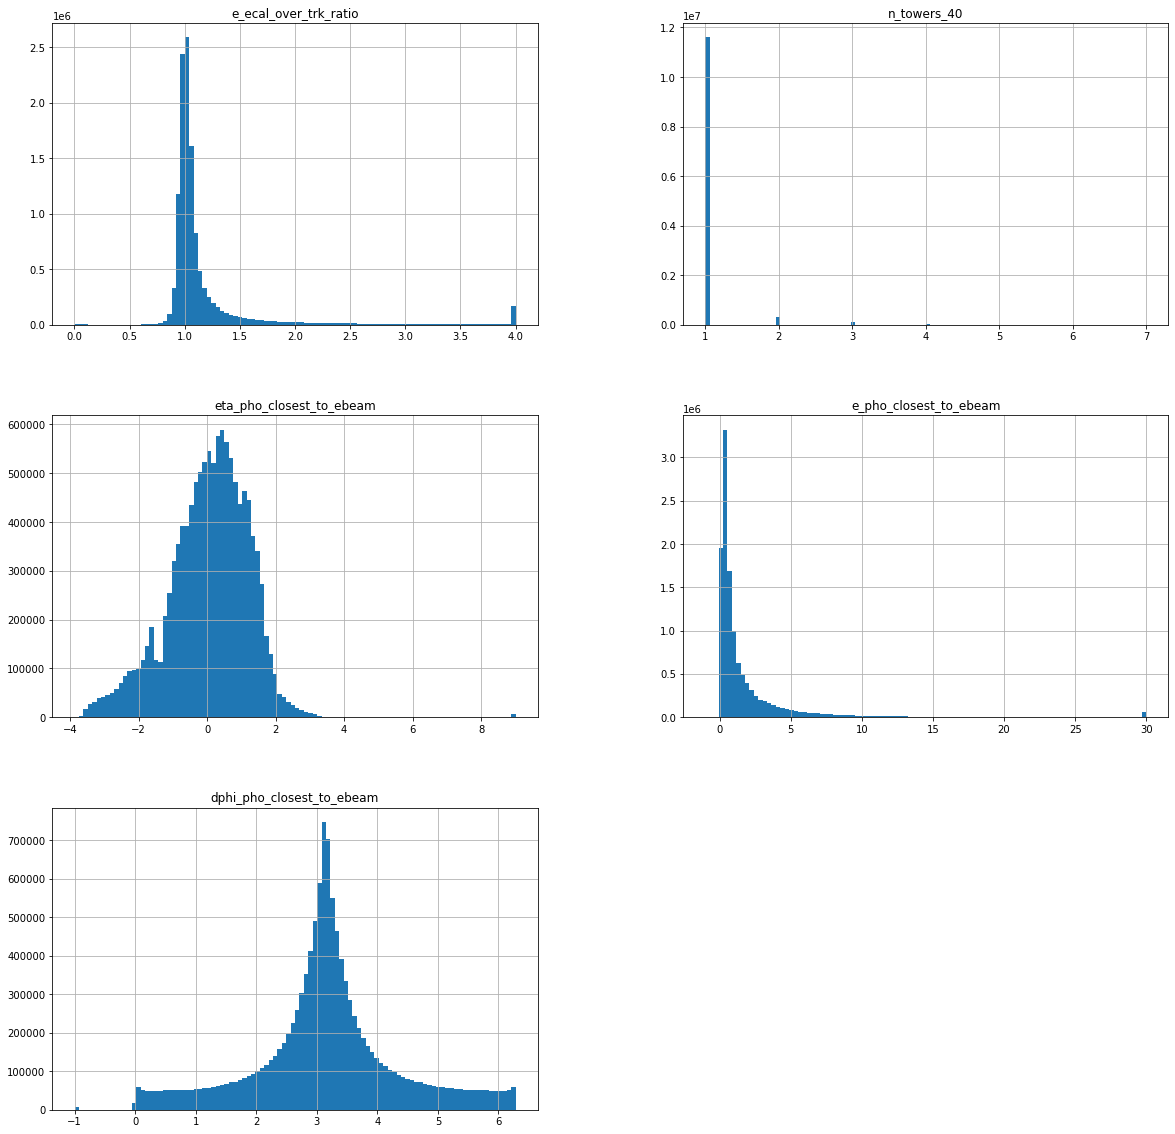

In [16]:

pandas_df.hist( figsize=(20,20), bins=100, column=[
                        'e_ecal_over_trk_ratio','n_towers_40',
                        'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'dphi_pho_closest_to_ebeam'])

plt.show()


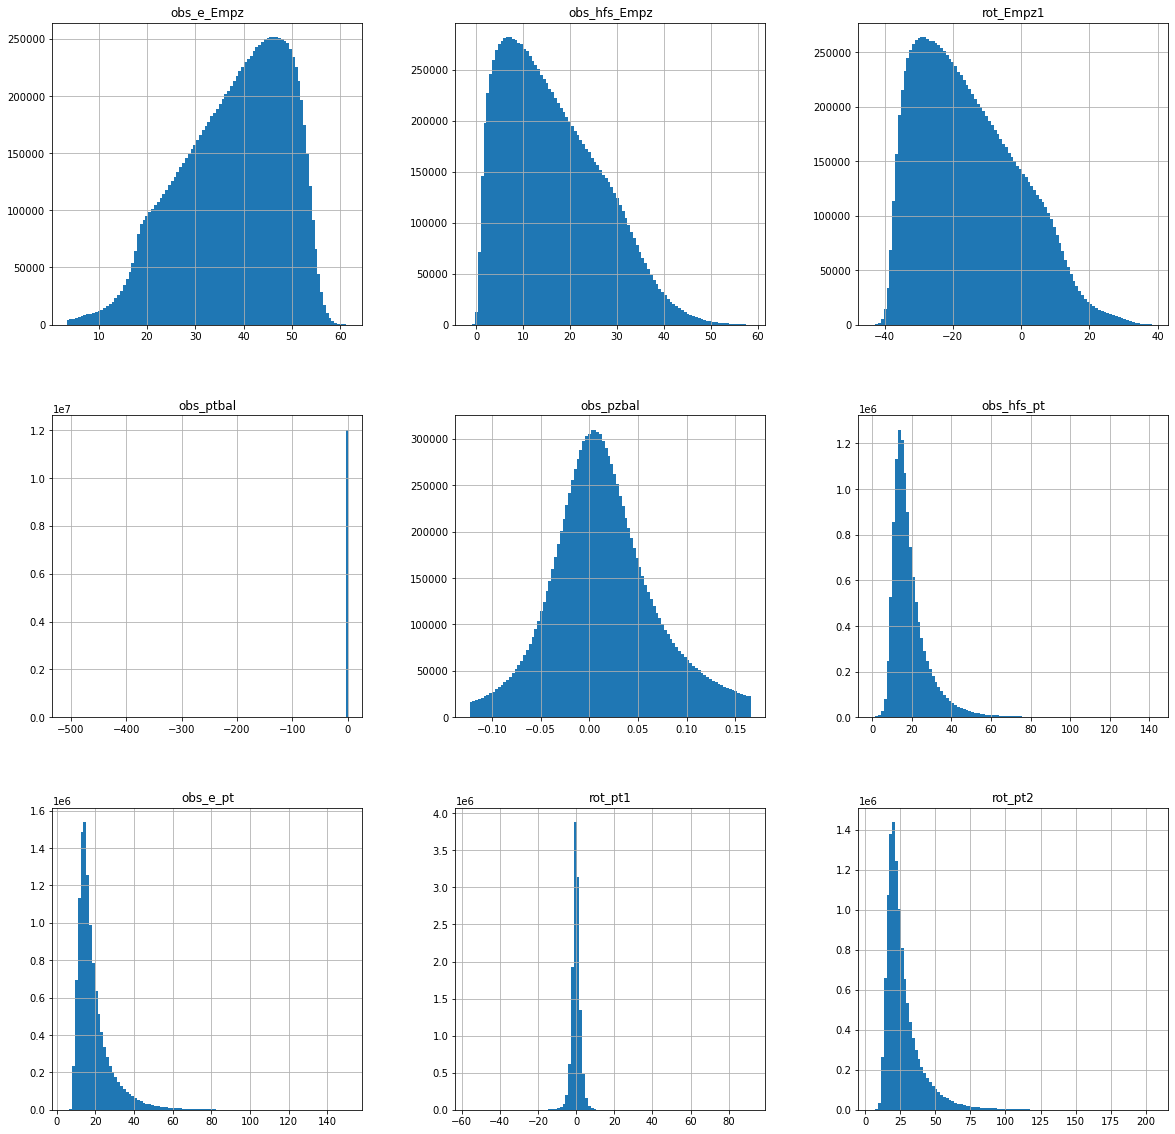

In [17]:
pandas_df.hist( figsize=(20,20), bins=100, column=[
    'obs_e_Empz','obs_hfs_Empz',
    'rot_Empz1',
#    'rot_Empz2',
    'obs_ptbal','obs_pzbal',
    'obs_hfs_pt','obs_e_pt',
    'rot_pt1','rot_pt2'] )

                                                   
plt.show()

## Set up machine learning stuff

In [18]:
os.environ['CUDA_VISIBLE_DEVICES']="2,3"
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pickle import dump

#-- Ben suggested to try this.  2021-08-07
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=10,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.experimental.set_memory_growth(physical_devices[1], True)

#####physical_devices = tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [19]:
X = np.c_[
    pandas_df['e_ecal_over_trk_ratio'].to_numpy(),
    pandas_df['n_towers_40'].to_numpy(),
    pandas_df['eta_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['e_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['dphi_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['obs_e_pz'].to_numpy(),
    pandas_df['obs_e_e'].to_numpy(),
    pandas_df['obs_hfs_pz'].to_numpy(),
    pandas_df['obs_hfs_e'].to_numpy(),
    pandas_df['rot_pt1'].to_numpy(),
    pandas_df['rot_Empz1'].to_numpy(),
    pandas_df['rot_pt2'].to_numpy(),
#    pandas_df['rot_Empz2'].to_numpy(),
    pandas_df['obs_pzbal'].to_numpy(),
    pandas_df['obs_ptbal'].to_numpy(),
    pandas_df['obs_dphi'].to_numpy(),
]

#-- targets for classification
Y = np.c_[ 
    pandas_df['gen_ptbal'].to_numpy(),
    pandas_df['gen_pzbal'].to_numpy(),
#    pandas_df['has_norad'].to_numpy(),
#    pandas_df['has_isr'].to_numpy(),
#    pandas_df['has_fsr'].to_numpy(),
]

#-- targets for regression
Y_r = np.c_[
    pandas_df['gen_log_x'].to_numpy(),
    pandas_df['gen_log_Q2'].to_numpy(),
    pandas_df['gen_log_y'].to_numpy(),
]

    
GY = pandas_df['from_tlv_gen_y'].to_numpy()

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

scalerY_c = StandardScaler()
scalerY_c.fit(Y)
Y = scalerY_c.transform(Y)

scalerY = StandardScaler()
scalerY.fit(Y_r)
Y_r = scalerY.transform(Y_r)

#-- Save the scaler transformations!  These are essential when reusing the training with a different dataset.

try:
    os.mkdir( '%s-scalers' % training_name )
except:
    print('\n  Dir %s-scalers already exists\n\n' % training_name )

    
print('\n\n Saving the input and learning target scalers:\n')
print('    %s-scalers/input_scaler.pkl' % training_name )
print('    %s-scalers/target_scaler.pkl' % training_name )
print('    %s-scalers/target_scaler_c.pkl' % training_name )
dump( scaler, open('%s-scalers/input_scaler.pkl' % training_name , 'wb'))
dump( scalerY, open('%s-scalers/target_scaler.pkl' % training_name , 'wb'))
dump( scalerY_c, open('%s-scalers/target_scaler_c.pkl' % training_name , 'wb'))

X_train, X_test,    Y_train, Y_test,    Y_r_train, Y_r_test,    GY_train, GY_test = train_test_split( X, Y, Y_r, GY,  test_size=0.5)
    



 Saving the input and learning target scalers:

    training_h1_classification_vDB-scalers/input_scaler.pkl
    training_h1_classification_vDB-scalers/target_scaler.pkl
    training_h1_classification_vDB-scalers/target_scaler_c.pkl


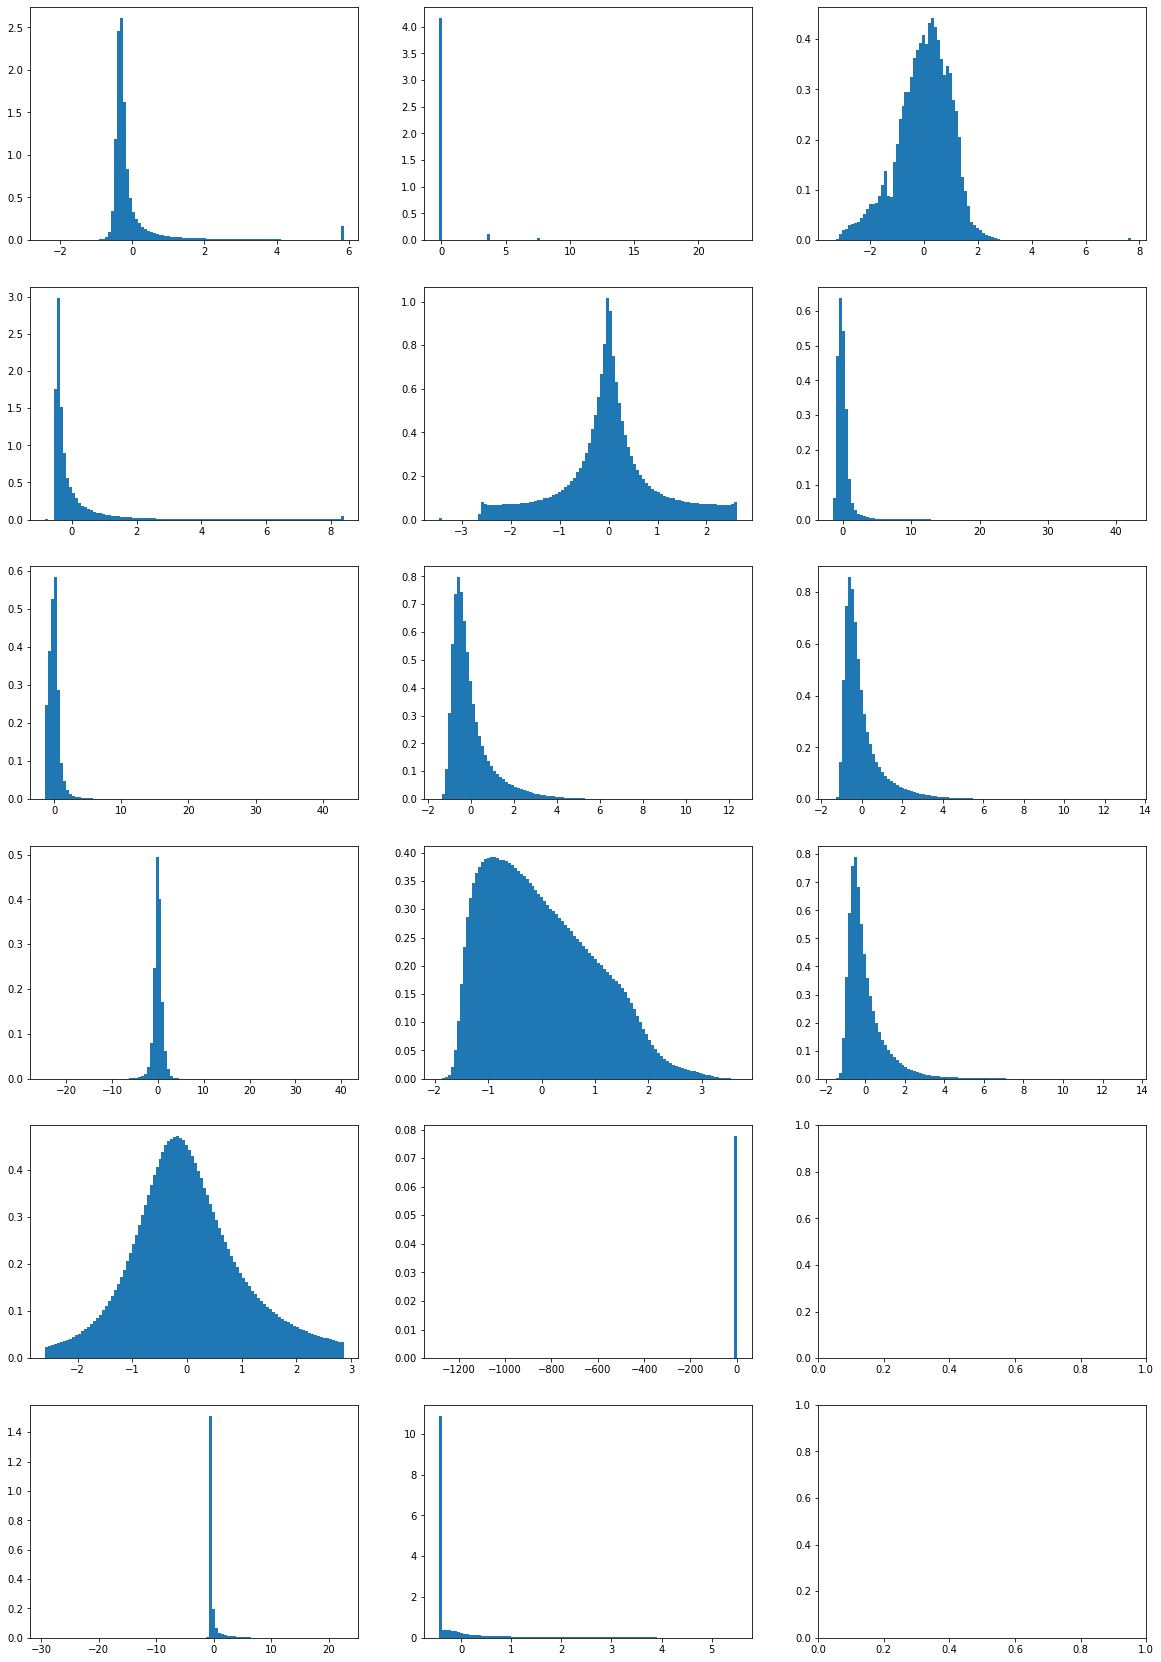

In [20]:
fig,ax = plt.subplots(6,3,figsize=(20,30))

ax[0][0].hist( X[:,0], density=True, bins=100 )
ax[0][1].hist( X[:,1], density=True, bins=100 )
ax[0][2].hist( X[:,2], density=True, bins=100 )

ax[1][0].hist( X[:,3], density=True, bins=100 )
ax[1][1].hist( X[:,4], density=True, bins=100 )
ax[1][2].hist( X[:,5], density=True, bins=100 )

ax[2][0].hist( X[:,6], density=True, bins=100 )
ax[2][1].hist( X[:,7], density=True, bins=100 )
ax[2][2].hist( X[:,8], density=True, bins=100 )

ax[3][0].hist( X[:,9], density=True, bins=100 )
ax[3][1].hist( X[:,10], density=True, bins=100 )
ax[3][2].hist( X[:,11], density=True, bins=100 )

ax[4][0].hist( X[:,12], density=True, bins=100 )
ax[4][1].hist( X[:,13], density=True, bins=100 )



ax[5][0].hist( Y[:,0], density=True, bins=100 )
ax[5][1].hist( Y[:,1], density=True, bins=100 )
#ax[5][2].hist( Y[:,2], density=True, bins=100 )

plt.show()

In [21]:
model = Sequential()

#-- initial layer
model.add(Dense(64, input_dim=15, activation='relu'))
model.add(Dropout(dropout_setval))

#-- middle part
model.add(Dense(128, activation='selu'))
model.add(Dropout(dropout_setval))
model.add(Dense(512, activation='selu'))
model.add(Dropout(dropout_setval))
model.add(Dense(1024, activation='selu'))
model.add(Dropout(dropout_setval))
model.add(Dense(512, activation='selu'))
model.add(Dropout(dropout_setval))
model.add(Dense(128, activation='selu'))
model.add(Dropout(dropout_setval))

#-- final layers
model.add(Dense(64, activation='selu'))
#model.add(Dense(3, activation='softmax'))
model.add(Dense(2, activation='linear'))

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval_cat)
#myloss = tf.keras.losses.CategoricalCrossentropy()
myloss = tf.keras.losses.Huber()

model.compile(loss=myloss, optimizer=opt, metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1024      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              5

In [22]:
%%time

batch_size_setval = 1024

hist = model.fit(
    X_train, Y_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X_test,Y_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
5875/5875 [==============================] - 32s 5ms/step - loss: 0.2134 - accuracy: 0.7353 - val_loss: 0.2075 - val_accuracy: 0.7858
Epoch 2/5000
5875/5875 [==============================] - 30s 5ms/step - loss: 0.2045 - accuracy: 0.7725 - val_loss: 0.2034 - val_accuracy: 0.7947
Epoch 3/5000
5875/5875 [==============================] - 30s 5ms/step - loss: 0.2029 - accuracy: 0.7816 - val_loss: 0.2023 - val_accuracy: 0.7985
Epoch 4/5000
5875/5875 [==============================] - 30s 5ms/step - loss: 0.2019 - accuracy: 0.7879 - val_loss: 0.2029 - val_accuracy: 0.7570
Epoch 5/5000
5875/5875 [==============================] - 30s 5ms/step - loss: 0.2013 - accuracy: 0.7917 - val_loss: 0.2007 - val_accuracy: 0.8006
Epoch 6/5000
5875/5875 [==============================] - 31s 5ms/step - loss: 0.2009 - accuracy: 0.7946 - val_loss: 0.2008 - val_accuracy: 0.7691
Epoch 7/5000
5875/5875 [==============================] - 30s 5ms/step - loss: 0.2005 - accuracy: 0.7974 - val_loss: 0

In [23]:
hist

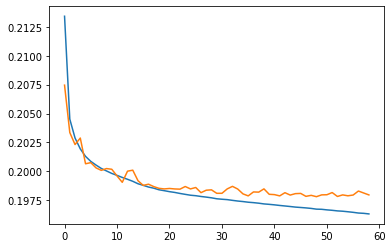

In [24]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

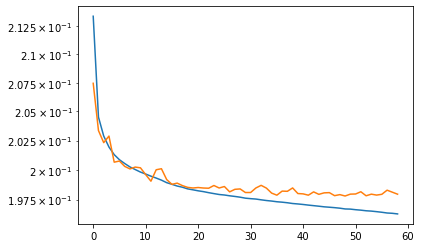

In [25]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')

In [26]:
tf.keras.models.save_model(model, '%s_classifier' % training_name )

INFO:tensorflow:Assets written to: training_h1_classification_vDB_classifier/assets


In [27]:
mypreds = model.predict(X_test,batch_size=1000)

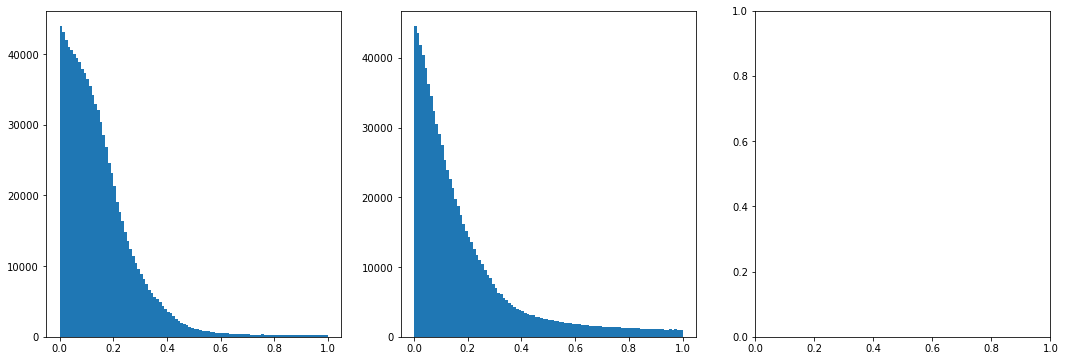

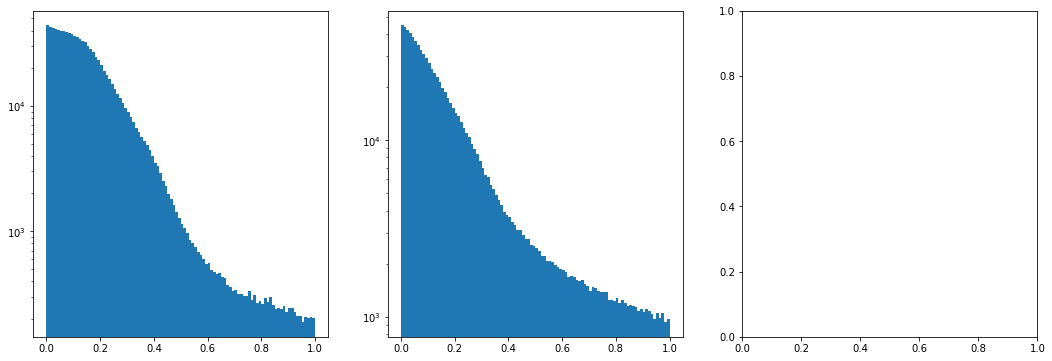

In [30]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].hist(mypreds[:,0],bins=100, range=[0,1] )
ax[1].hist(mypreds[:,1],bins=100, range=[0,1] )
#ax[2].hist(mypreds[:,2],bins=100, range=[0,1] )
plt.show()

fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].hist(mypreds[:,0],bins=100, range=[0,1], log=True )
ax[1].hist(mypreds[:,1],bins=100, range=[0,1], log=True )
#ax[2].hist(mypreds[:,2],bins=100, range=[0,1] )
plt.show()





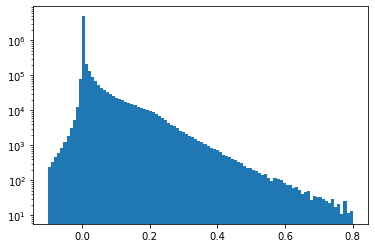

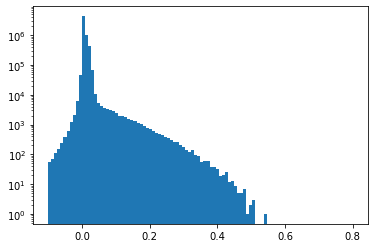

In [32]:

inv_trans_Y    = scalerY_c.inverse_transform(Y_test)
inv_trans_pred = scalerY_c.inverse_transform(mypreds)
true_vals = inv_trans_Y 
pred_vals = inv_trans_pred


plt.hist(true_vals[:,0],bins=100,range=[-0.1,0.8],log=True)
plt.show()
plt.hist(pred_vals[:,0],bins=100,range=[-0.1,0.8],log=True)
plt.show()


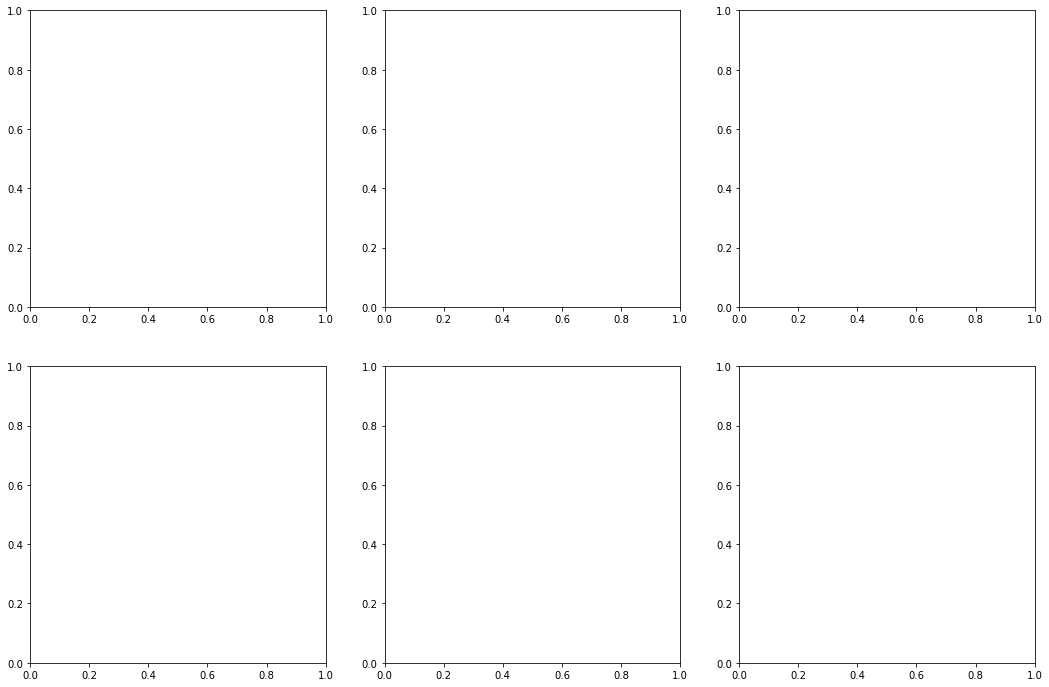

In [33]:
fig,ax = plt.subplots(2,3,figsize=(18,12))

#ax[0][0].hist(mypreds[:,0][Y_test[:,0]>0.5],bins=100, range=[0,1] )
#ax[0][1].hist(mypreds[:,1][Y_test[:,1]>0.5],bins=100, range=[0,1] )
#ax[0][2].hist(mypreds[:,2][Y_test[:,2]>0.5],bins=100, range=[0,1] )

#ax[1][0].hist(mypreds[:,0][Y_test[:,0]<0.5],bins=100, range=[0,1] )
#ax[1][1].hist(mypreds[:,1][Y_test[:,1]<0.5],bins=100, range=[0,1] )
#ax[1][2].hist(mypreds[:,2][Y_test[:,2]<0.5],bins=100, range=[0,1] )

#ax[1][0].hist(mypreds[:,0][Y_test[:,0]>0.5],bins=100, range=[0,1], alpha=0.6 )
#ax[1][1].hist(mypreds[:,1][Y_test[:,1]>0.5],bins=100, range=[0,1], alpha=0.6 )
#ax[1][2].hist(mypreds[:,2][Y_test[:,2]>0.5],bins=100, range=[0,1], alpha=0.6 )



plt.show()

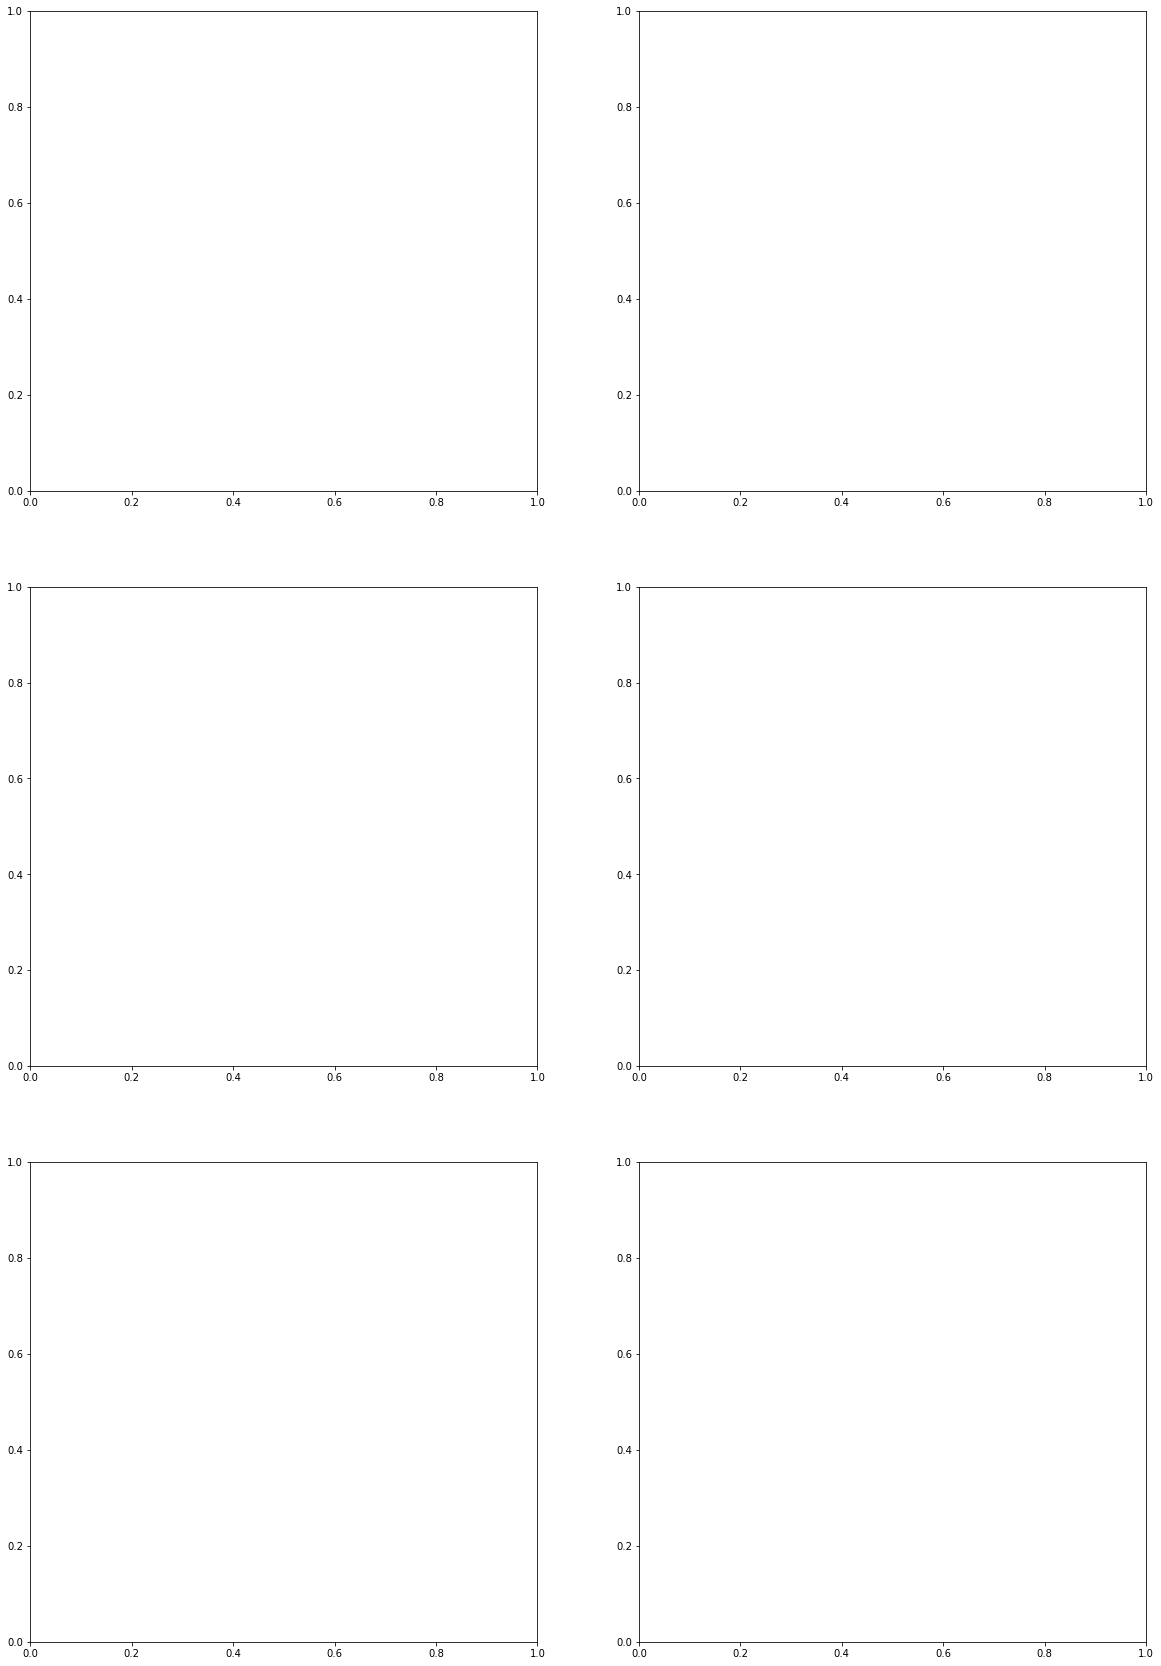

In [34]:
fig,ax = plt.subplots(3,2,figsize=(20,30))

#ax[0][0].hist2d( mypreds[:,1][Y_test[:,0]>0.5], mypreds[:,2][Y_test[:,0]>0.5], bins=100, norm=mpl.colors.LogNorm())
#ax[0][1].hist2d( mypreds[:,1][Y_test[:,0]<0.5], mypreds[:,2][Y_test[:,0]<0.5], bins=100, norm=mpl.colors.LogNorm())

#ax[1][0].hist2d( mypreds[:,1][Y_test[:,1]>0.5], mypreds[:,2][Y_test[:,1]>0.5], bins=100, norm=mpl.colors.LogNorm())
#ax[1][1].hist2d( mypreds[:,1][Y_test[:,1]<0.5], mypreds[:,2][Y_test[:,1]<0.5], bins=100, norm=mpl.colors.LogNorm())

#ax[2][0].hist2d( mypreds[:,1][Y_test[:,2]>0.5], mypreds[:,2][Y_test[:,2]>0.5], bins=100, norm=mpl.colors.LogNorm())
#ax[2][1].hist2d( mypreds[:,1][Y_test[:,2]<0.5], mypreds[:,2][Y_test[:,2]<0.5], bins=100, norm=mpl.colors.LogNorm())



plt.show()

In [35]:
mypreds

array([[ 0.01350404, -0.11200809],
       [-0.23069374, -0.1721925 ],
       [-0.23048465, -0.3920542 ],
       ...,
       [-0.24428369, -0.36928698],
       [-0.1580923 , -0.28243306],
       [-0.16609626, -0.21305092]], dtype=float32)

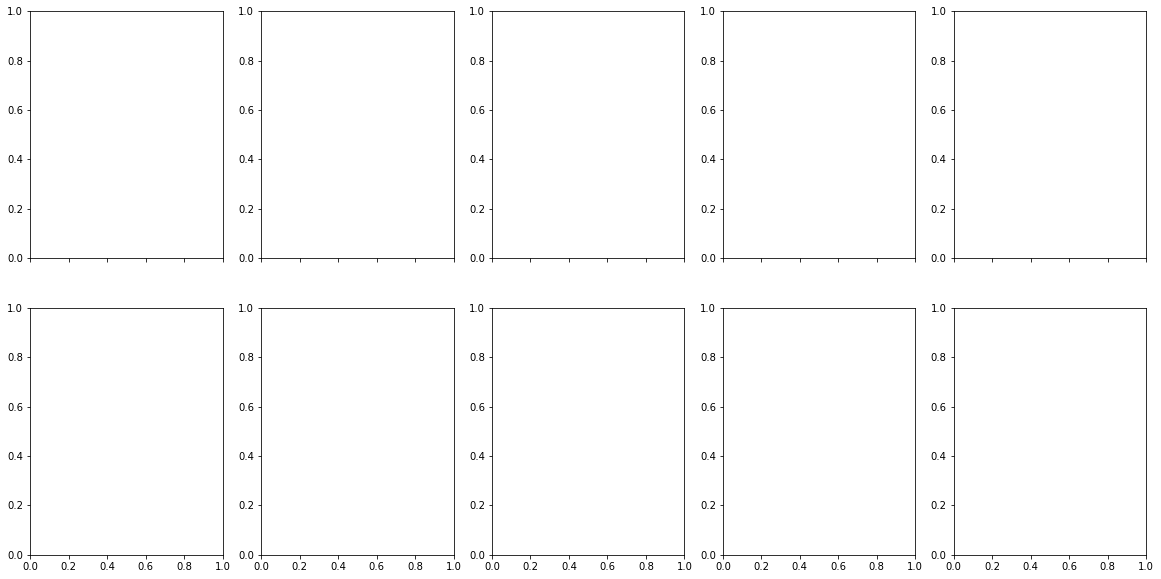

In [36]:
fig,ax = plt.subplots(2,5,figsize=(20,10), sharex='col')

#ax[0][0].hist( X_test[:,0][mypreds[:,1]>0.5], density=True, range=(-2,5), bins=100 )
#ax[0][1].hist( X_test[:,1][mypreds[:,1]>0.5], density=True, range=(-10,20), bins=10 )
#ax[0][2].hist( X_test[:,2][mypreds[:,1]>0.5], density=True, bins=100 )
#ax[0][4].hist( X_test[:,4][mypreds[:,1]>0.5], density=True, range=(-3,3), bins=100 )

#ax[1][0].hist( X_test[:,0][mypreds[:,1]<0.5], density=True, range=(-2,5), bins=100 )
#ax[1][1].hist( X_test[:,1][mypreds[:,1]<0.5], density=True, range=(-10,20), bins=10 )
#ax[1][2].hist( X_test[:,2][mypreds[:,1]<0.5], density=True, bins=100 )
#ax[1][3].hist( X_test[:,3][mypreds[:,1]<0.5], density=True, range=(-2,10), bins=100 )
#ax[1][4].hist( X_test[:,4][mypreds[:,1]<0.5], density=True, range=(-3,3), bins=100 )


plt.show()

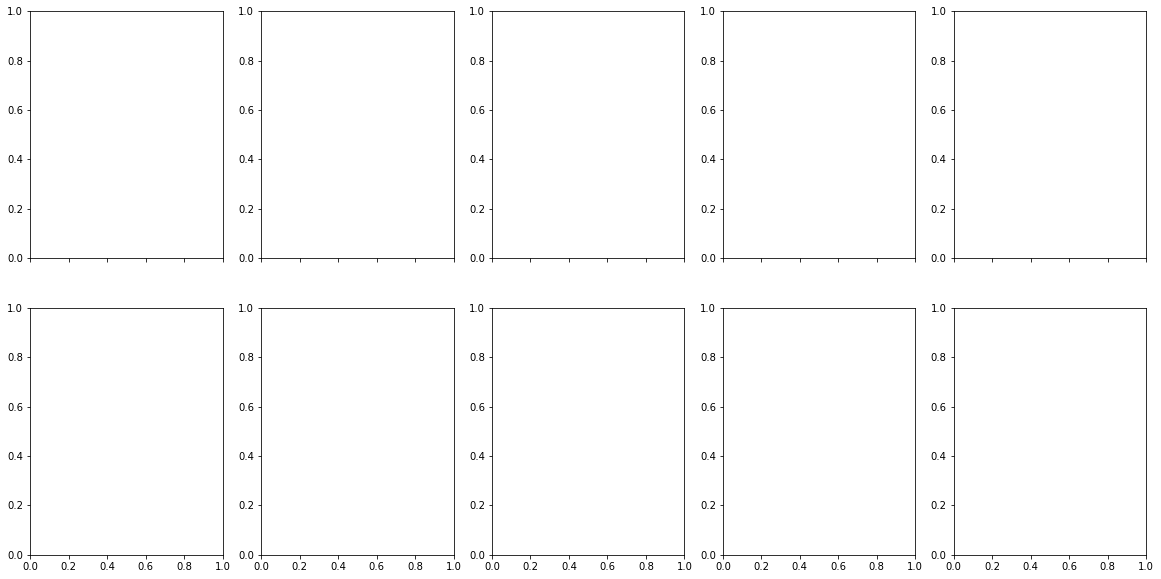

In [37]:
fig,ax = plt.subplots(2,5,figsize=(20,10), sharex='col')

#ax[0][0].hist( X_test[:,0][mypreds[:,2]>0.5], density=True, range=(-2,5), bins=100 )
#ax[0][1].hist( X_test[:,1][mypreds[:,2]>0.5], density=True, range=(-10,20), bins=10 )
#ax[0][2].hist( X_test[:,2][mypreds[:,2]>0.5], density=True, bins=100 )
#ax[0][3].hist( X_test[:,3][mypreds[:,2]>0.5], density=True, range=(-2,10), bins=100 )
#ax[0][4].hist( X_test[:,4][mypreds[:,2]>0.5], density=True, range=(-3,3), bins=100 )

#ax[1][0].hist( X_test[:,0][mypreds[:,2]<0.5], density=True, range=(-2,5), bins=100 )
#ax[1][1].hist( X_test[:,1][mypreds[:,2]<0.5], density=True, range=(-10,20), bins=10 )
#ax[1][2].hist( X_test[:,2][mypreds[:,2]<0.5], density=True, bins=100 )
#ax[1][3].hist( X_test[:,3][mypreds[:,2]<0.5], density=True, range=(-2,10), bins=100 )
#ax[1][4].hist( X_test[:,4][mypreds[:,2]<0.5], density=True, range=(-3,3), bins=100 )


plt.show()

## Now, add classification outputs to the set of inputs for the regression

In [38]:
X_train

array([[-0.3872709 , -0.17577518,  0.37625745, ...,  0.4455569 ,
         0.21078945, -0.47488957],
       [-0.37944999, -0.17577518,  0.27165767, ...,  1.07843955,
        -0.17903012, -1.20042313],
       [ 5.28221896, -0.17577518,  1.55609664, ..., -0.10088329,
         0.11154923, -0.06835088],
       ...,
       [-0.39573082, -0.17577518, -0.82848777, ...,  0.62068405,
        -0.1174756 ,  0.18752362],
       [-0.18236952, -0.17577518, -2.79080576, ..., -0.20727461,
        -0.5072425 , -1.17174444],
       [-0.85675801, -0.17577518, -0.15558046, ...,  2.70419116,
         0.62343453, -0.4030175 ]])

In [51]:
mypreds_train = model.predict(X_train,batch_size=1000)

In [52]:
mypreds_train

array([[-0.22215609, -0.24174212],
       [-0.24723984, -0.1287641 ],
       [-0.11728244, -0.19948395],
       ...,
       [-0.25658208, -0.38234666],
       [-0.1775585 , -0.09621799],
       [-0.26108986, -0.36471096]], dtype=float32)

In [55]:
X_merged_train = np.append(X_train, mypreds_train,1)


In [58]:
print(len(mypreds_train[0]))
print(len(X_train[0]))
print(len(X_merged_train[0]))

2
15
17


In [59]:
X_merged_train

array([[-0.3872709 , -0.17577518,  0.37625745, ..., -0.47488957,
        -0.22215609, -0.24174212],
       [-0.37944999, -0.17577518,  0.27165767, ..., -1.20042313,
        -0.24723984, -0.12876409],
       [ 5.28221896, -0.17577518,  1.55609664, ..., -0.06835088,
        -0.11728244, -0.19948395],
       ...,
       [-0.39573082, -0.17577518, -0.82848777, ...,  0.18752362,
        -0.25658208, -0.38234666],
       [-0.18236952, -0.17577518, -2.79080576, ..., -1.17174444,
        -0.1775585 , -0.09621799],
       [-0.85675801, -0.17577518, -0.15558046, ..., -0.4030175 ,
        -0.26108986, -0.36471096]])

In [60]:
X_test

array([[-0.10591235, -0.17577518, -0.26889738, ...,  2.42668356,
        -1.36679387, -0.37600069],
       [-0.39224526, -0.17577518, -0.29650216, ...,  0.99729965,
         0.09319452, -0.13874869],
       [-0.28549701, -0.17577518,  0.24627751, ..., -1.26405715,
         0.48085611,  0.66181318],
       ...,
       [-0.34088097, -0.17577518, -0.34762664, ...,  0.32206944,
        -0.10893301, -0.39840487],
       [-0.30832175, -0.17577518, -0.68437245, ...,  0.39542775,
         0.29204532, -0.18377819],
       [-0.26056123, -0.17577518,  0.79607037, ...,  0.25427966,
        -0.01566539, -0.39982998]])

In [61]:
mypreds

array([[ 0.01350404, -0.11200809],
       [-0.23069374, -0.1721925 ],
       [-0.23048465, -0.3920542 ],
       ...,
       [-0.24428369, -0.36928698],
       [-0.1580923 , -0.28243306],
       [-0.16609626, -0.21305092]], dtype=float32)

In [62]:
X_merged_test = np.append(X_test, mypreds,1)

In [63]:
X_merged_test

array([[-0.10591235, -0.17577518, -0.26889738, ..., -0.37600069,
         0.01350404, -0.11200809],
       [-0.39224526, -0.17577518, -0.29650216, ..., -0.13874869,
        -0.23069374, -0.1721925 ],
       [-0.28549701, -0.17577518,  0.24627751, ...,  0.66181318,
        -0.23048465, -0.3920542 ],
       ...,
       [-0.34088097, -0.17577518, -0.34762664, ..., -0.39840487,
        -0.24428369, -0.36928698],
       [-0.30832175, -0.17577518, -0.68437245, ..., -0.18377819,
        -0.15809231, -0.28243306],
       [-0.26056123, -0.17577518,  0.79607037, ..., -0.39982998,
        -0.16609626, -0.21305092]])

In [64]:
len(X_merged_test[0])

17

## Set up the regression network

In [65]:
model_r = Sequential()

#-- initial layer
model_r.add(Dense(64, input_dim=17, activation='relu'))
model_r.add(Dropout(dropout_setval))

#-- middle part
model_r.add(Dense(128, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(512, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(1024, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(512, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(128, activation='selu'))
model_r.add(Dropout(dropout_setval))

#-- final layers
model_r.add(Dense(64, activation='selu'))
model_r.add(Dense(3, activation='linear'))

opt_r = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval_reg)
myloss_r = tf.keras.losses.Huber()

model_r.compile(loss=myloss_r, optimizer=opt_r, metrics=['accuracy'])

model_r.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                1152      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)             

In [66]:
%%time

hist_r = model_r.fit(
    X_merged_train, Y_r_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X_merged_test,Y_r_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
5875/5875 [==============================] - 33s 5ms/step - loss: 0.0157 - accuracy: 0.9461 - val_loss: 0.0076 - val_accuracy: 0.9600
Epoch 2/5000
5875/5875 [==============================] - 31s 5ms/step - loss: 0.0066 - accuracy: 0.9628 - val_loss: 0.0060 - val_accuracy: 0.9643
Epoch 3/5000
5875/5875 [==============================] - 30s 5ms/step - loss: 0.0057 - accuracy: 0.9656 - val_loss: 0.0055 - val_accuracy: 0.9661
Epoch 4/5000
5875/5875 [==============================] - 30s 5ms/step - loss: 0.0053 - accuracy: 0.9669 - val_loss: 0.0052 - val_accuracy: 0.9673
Epoch 5/5000
5875/5875 [==============================] - 30s 5ms/step - loss: 0.0050 - accuracy: 0.9678 - val_loss: 0.0050 - val_accuracy: 0.9680
Epoch 6/5000
5875/5875 [==============================] - 30s 5ms/step - loss: 0.0048 - accuracy: 0.9683 - val_loss: 0.0051 - val_accuracy: 0.9676
Epoch 7/5000
5875/5875 [==============================] - 30s 5ms/step - loss: 0.0047 - accuracy: 0.9688 - val_loss: 0

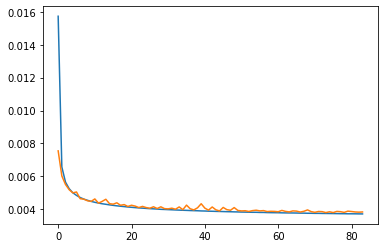

In [67]:
plt.plot(hist_r.history['loss'])
plt.plot(hist_r.history['val_loss'])

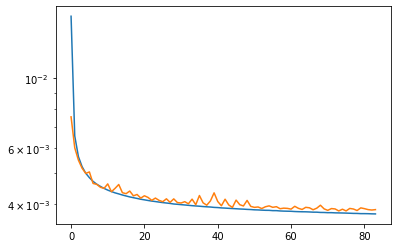

In [68]:
plt.plot(hist_r.history['loss'])
plt.plot(hist_r.history['val_loss'])
plt.yscale('log')

In [69]:
tf.keras.models.save_model(model_r, '%s_regression' % training_name )

INFO:tensorflow:Assets written to: training_h1_classification_vDB_regression/assets


In [70]:
mypreds_r = model_r.predict(X_merged_test,batch_size=1000)

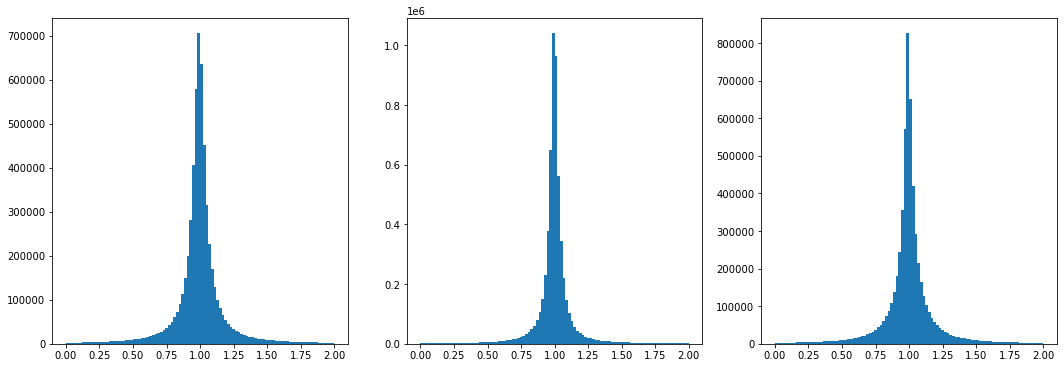

In [71]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].hist(mypreds_r[:,0]/Y_r_test[:,0],bins=100, range=[0,2] )
ax[1].hist(mypreds_r[:,1]/Y_r_test[:,1],bins=100, range=[0,2] )
ax[2].hist(mypreds_r[:,2]/Y_r_test[:,2],bins=100, range=[0,2] )
plt.show()

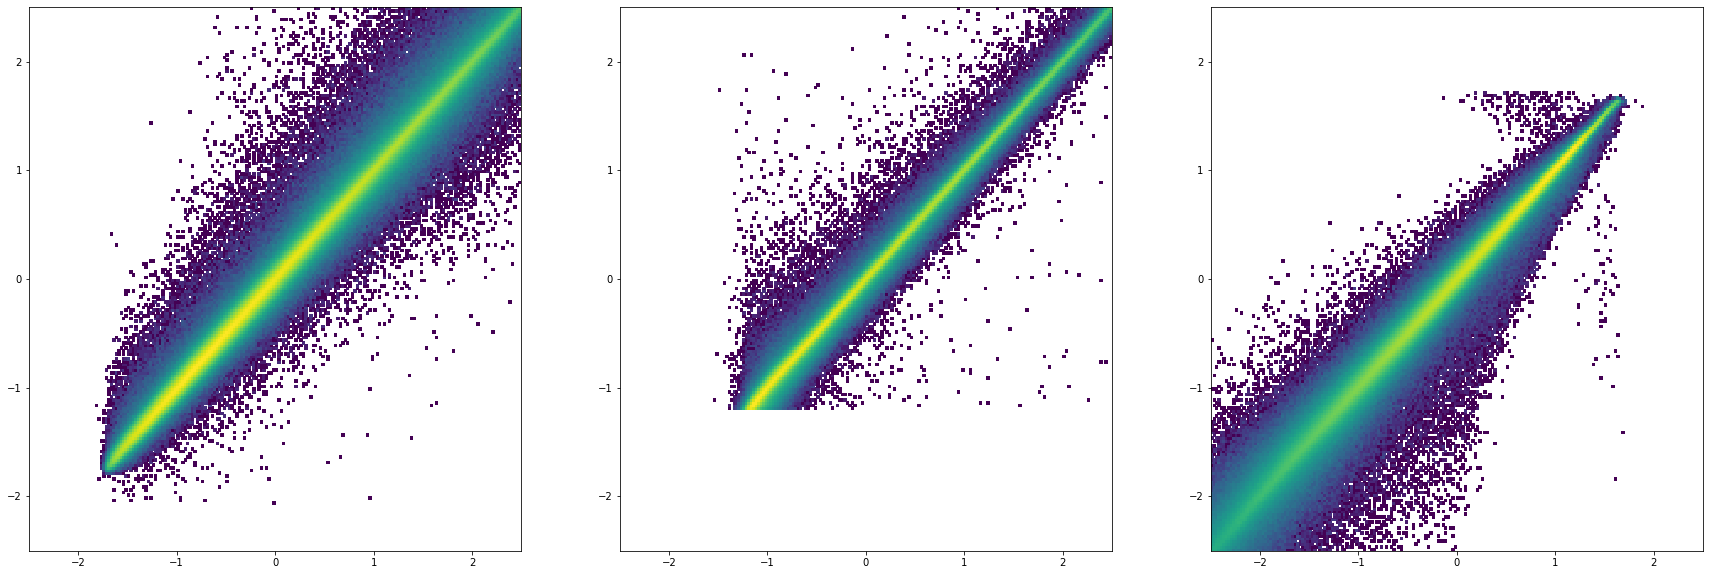

In [72]:
fig,ax = plt.subplots(1,3,figsize=(30,10))
ax[0].hist2d(mypreds_r[:,0],Y_r_test[:,0],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[1].hist2d(mypreds_r[:,1],Y_r_test[:,1],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[2].hist2d(mypreds_r[:,2],Y_r_test[:,2],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
plt.show()

In [73]:
inv_trans_Y = scalerY.inverse_transform(Y_r_test)
inv_trans_pred = scalerY.inverse_transform(mypreds_r)
true_vals = np.exp( inv_trans_Y )
pred_vals = np.exp( inv_trans_pred )

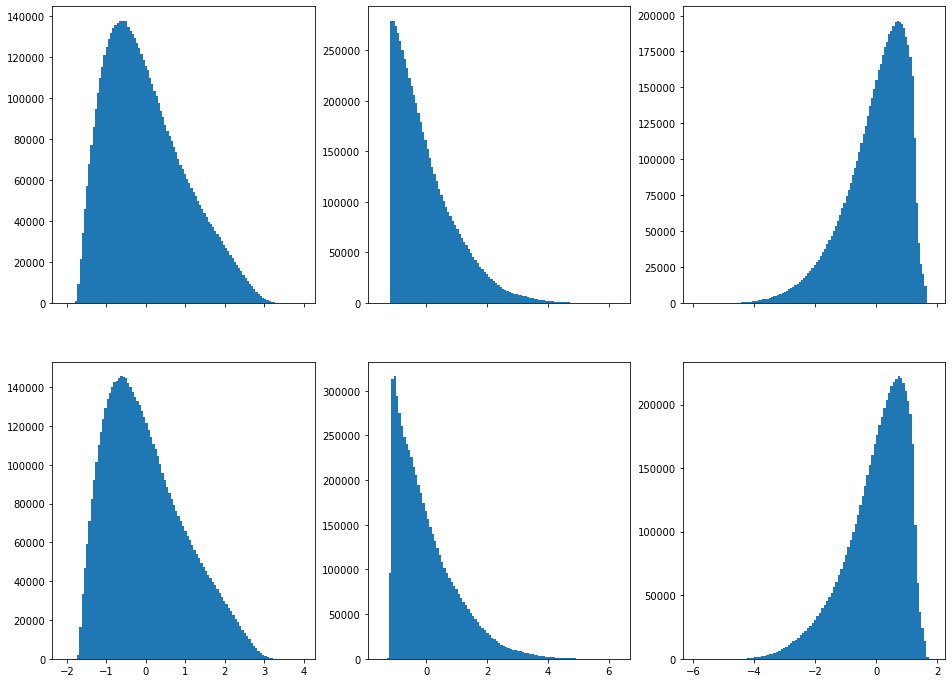

In [74]:
fig,ax = plt.subplots(2,3,figsize=(16,12), sharex='col')

ax[0][0].hist(Y_r_test[:,0], bins=100)
ax[0][1].hist(Y_r_test[:,1], bins=100)
ax[0][2].hist(Y_r_test[:,2], bins=100)

ax[1][0].hist(mypreds_r[:,0], bins=100)
ax[1][1].hist(mypreds_r[:,1], bins=100)
ax[1][2].hist(mypreds_r[:,2], bins=100)


plt.show()

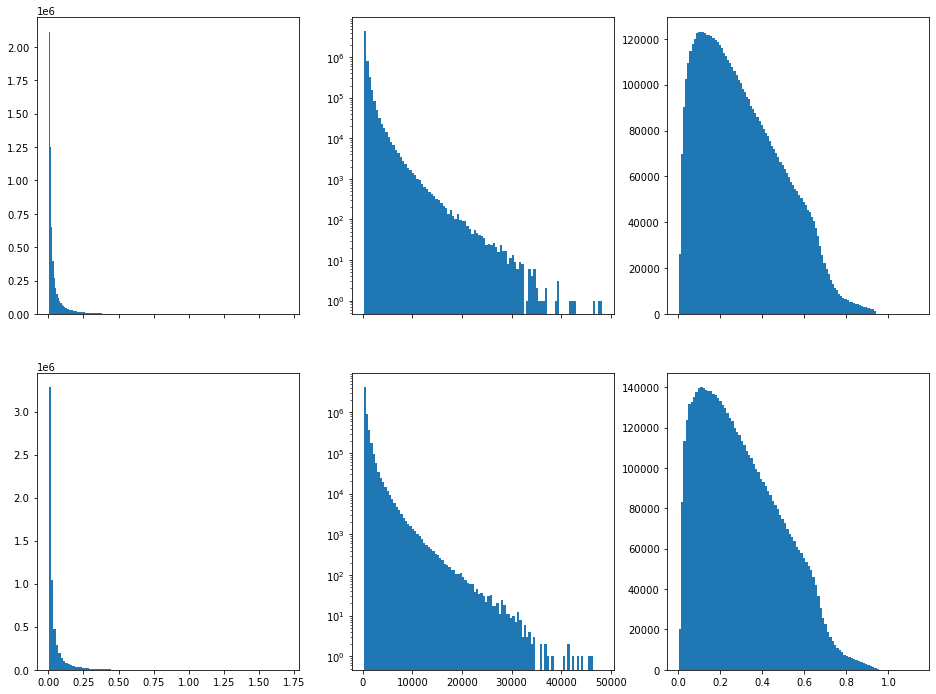

In [75]:
fig,ax = plt.subplots(2,3,figsize=(16,12), sharex='col' )



ax[0][0].hist(true_vals[:,0], bins=100)
ax[0][1].hist(true_vals[:,1], bins=100)
ax[0][2].hist(true_vals[:,2], bins=100)

ax[1][0].hist(pred_vals[:,0], bins=100)
ax[1][1].hist(pred_vals[:,1], bins=100)
ax[1][2].hist(pred_vals[:,2], bins=100)


ax[0][1].set_yscale('log')
ax[1][1].set_yscale('log')


plt.show()

## Plots of pred/true of training target variables : transformed log(x), log(y), and log(Q2)

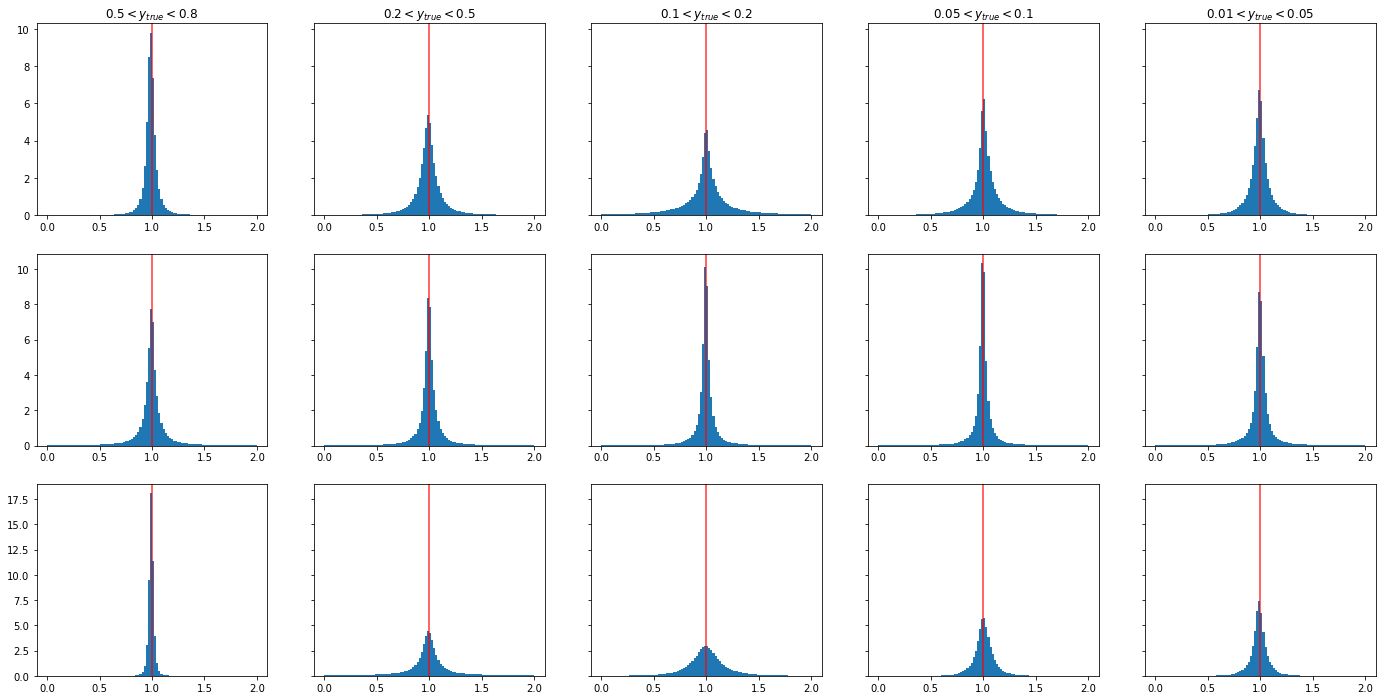

In [76]:
fig,ax = plt.subplots(3,5,figsize=(24,12),sharey='row')

for i in range(3):
    ax[i][0].hist(mypreds_r[:,i][(GY_test > 0.5)*(GY_test < 0.8)]/Y_r_test[(GY_test > 0.5)*(GY_test < 0.8)][:,i],density=True,bins=100,range=(0,2))
    ax[i][1].hist(mypreds_r[:,i][(GY_test > 0.2)*(GY_test < 0.5)]/Y_r_test[(GY_test > 0.2)*(GY_test < 0.5)][:,i],density=True,bins=100,range=(0,2))
    ax[i][2].hist(mypreds_r[:,i][(GY_test > 0.1)*(GY_test < 0.2)]/Y_r_test[(GY_test > 0.1)*(GY_test < 0.2)][:,i],density=True,bins=100,range=(0,2))
    ax[i][3].hist(mypreds_r[:,i][(GY_test > 0.05)*(GY_test < 0.1)]/Y_r_test[(GY_test > 0.05)*(GY_test < 0.1)][:,i],density=True,bins=100,range=(0,2))
    ax[i][4].hist(mypreds_r[:,i][(GY_test > 0.01)*(GY_test < 0.05)]/Y_r_test[(GY_test > 0.01)*(GY_test < 0.05)][:,i],density=True,bins=100,range=(0,2))



ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[0][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    ax[1][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    ax[2][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()


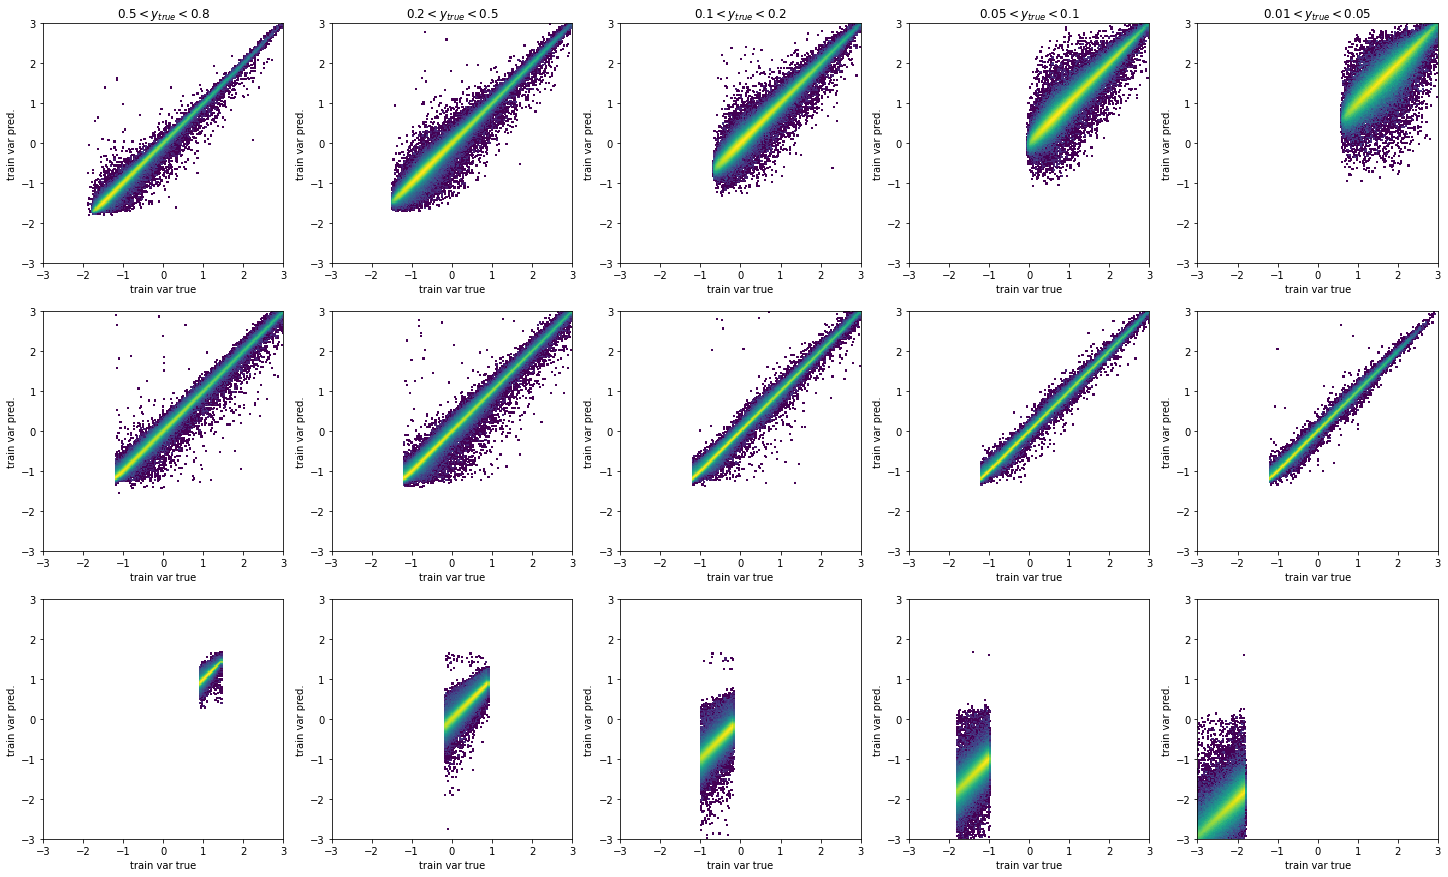

In [77]:
fig,ax = plt.subplots(3,5,figsize=(25,15))


for i in range(3):
    ax[i][0].hist2d( Y_r_test[(GY_test > 0.5)*(GY_test < 0.8)][:,i],
              mypreds_r[:,i][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][1].hist2d( Y_r_test[(GY_test > 0.2)*(GY_test < 0.5)][:,i],
              mypreds_r[:,i][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][2].hist2d( Y_r_test[(GY_test > 0.1)*(GY_test < 0.2)][:,i],
              mypreds_r[:,i][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][3].hist2d( Y_r_test[(GY_test > 0.05)*(GY_test < 0.1)][:,i],
              mypreds_r[:,i][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][4].hist2d( Y_r_test[(GY_test > 0.01)*(GY_test < 0.05)][:,i],
              mypreds_r[:,i][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())
    
ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')




for i in range(5):
    ax[0][i].set_ylabel('train var pred.')
    ax[0][i].set_xlabel('train var true')
    ax[1][i].set_ylabel('train var pred.')
    ax[1][i].set_xlabel('train var true')
    ax[2][i].set_ylabel('train var pred.')
    ax[2][i].set_xlabel('train var true')



    
plt.show()


## Plots of predicted and true physics variable : x

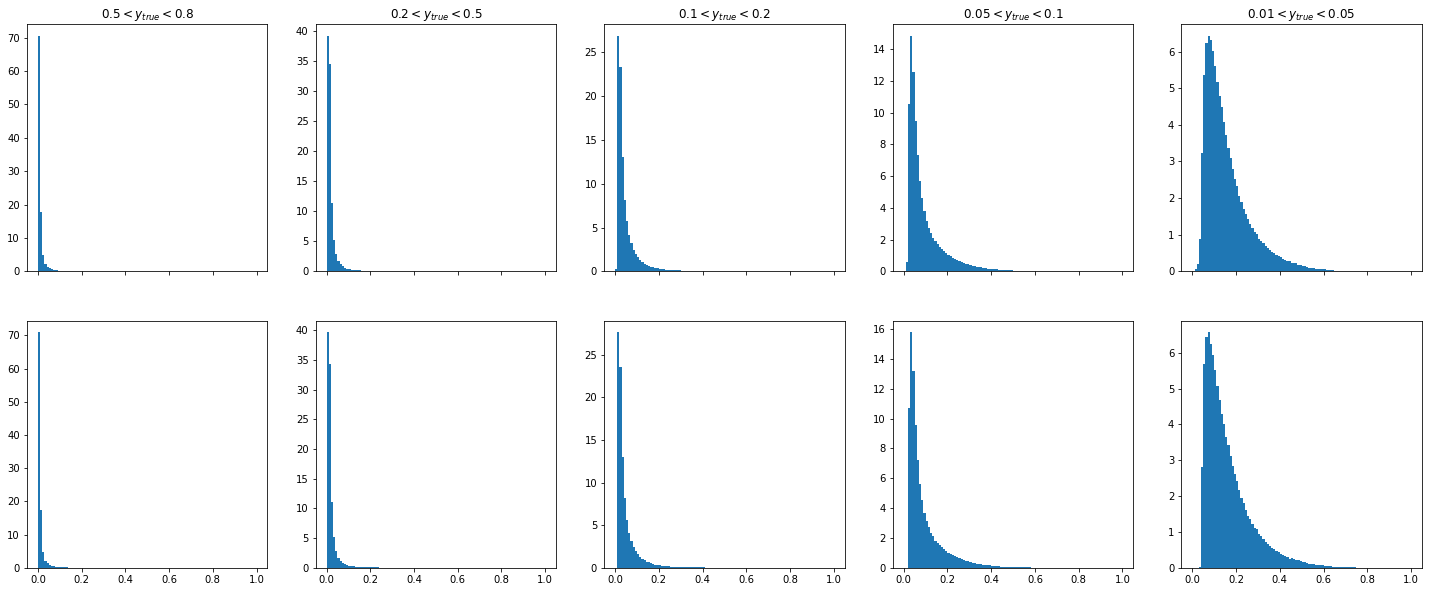

In [78]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

ax[0][0].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,1))
ax[0][1].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,1))
ax[0][2].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,1))
ax[0][3].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,1))
ax[0][4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,1))

ax[1][0].hist(true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,1))
ax[1][1].hist(true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,1))
ax[1][2].hist(true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,1))
ax[1][3].hist(true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,1))
ax[1][4].hist(true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,1))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

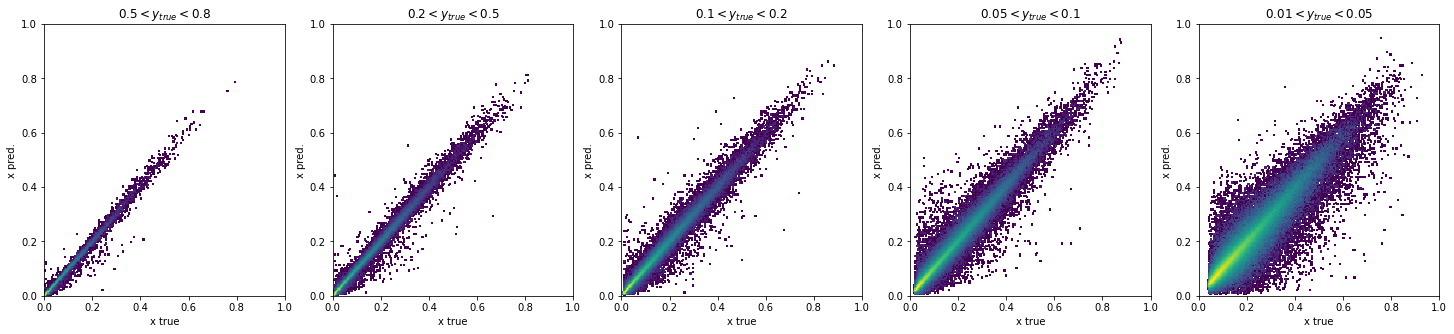

In [79]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

ax[0].hist2d( true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('x pred.')
    ax[i].set_xlabel('x true')


    
plt.show()

## Plots of predicted and true physics variable : Q2

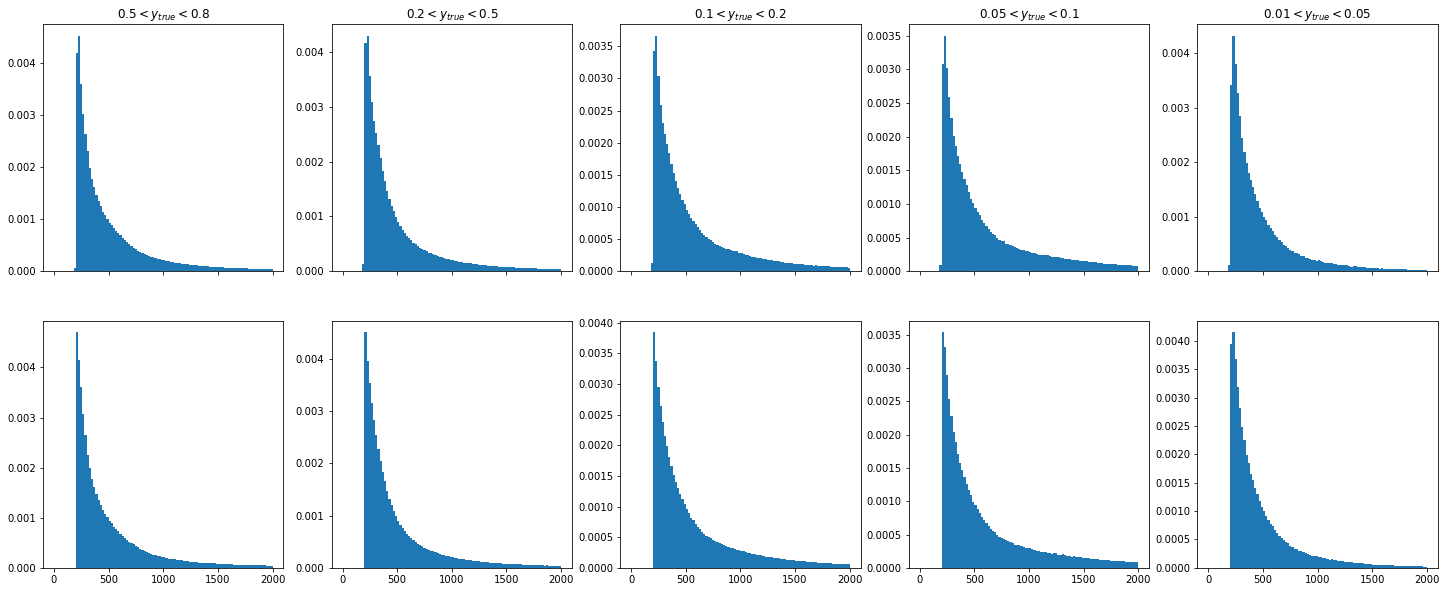

In [80]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

xmax = 2000

ax[0][0].hist(pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[0][1].hist(pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[0][2].hist(pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[0][3].hist(pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[0][4].hist(pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))

ax[1][0].hist(true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[1][1].hist(true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[1][2].hist(true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[1][3].hist(true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[1][4].hist(true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

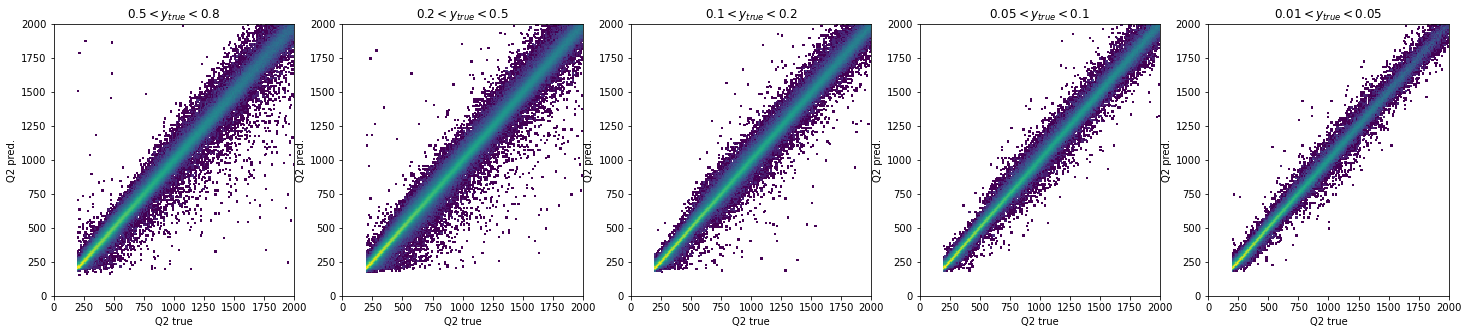

In [81]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

axis_max = 2000

ax[0].hist2d( true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('Q2 pred.')
    ax[i].set_xlabel('Q2 true')


    
plt.show()

## Plots of predicted and true physics variable : y

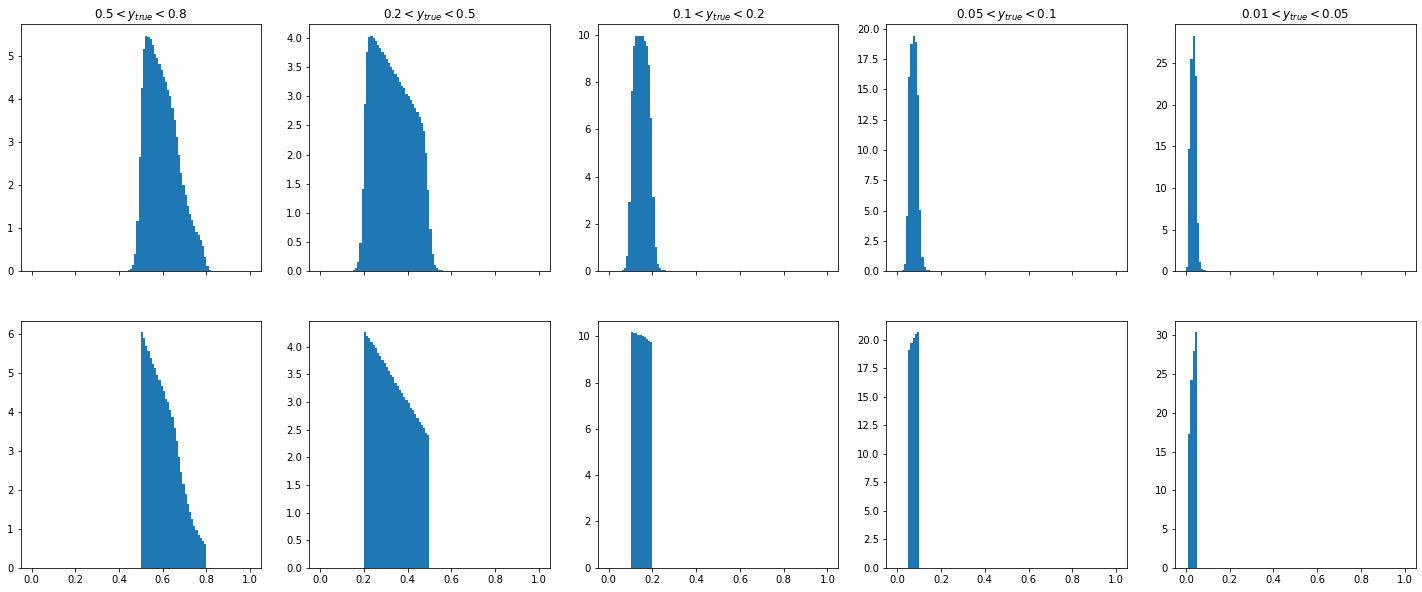

In [82]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

xmax = 1

ax[0][0].hist(pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[0][1].hist(pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[0][2].hist(pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[0][3].hist(pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[0][4].hist(pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))

ax[1][0].hist(true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[1][1].hist(true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[1][2].hist(true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[1][3].hist(true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[1][4].hist(true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

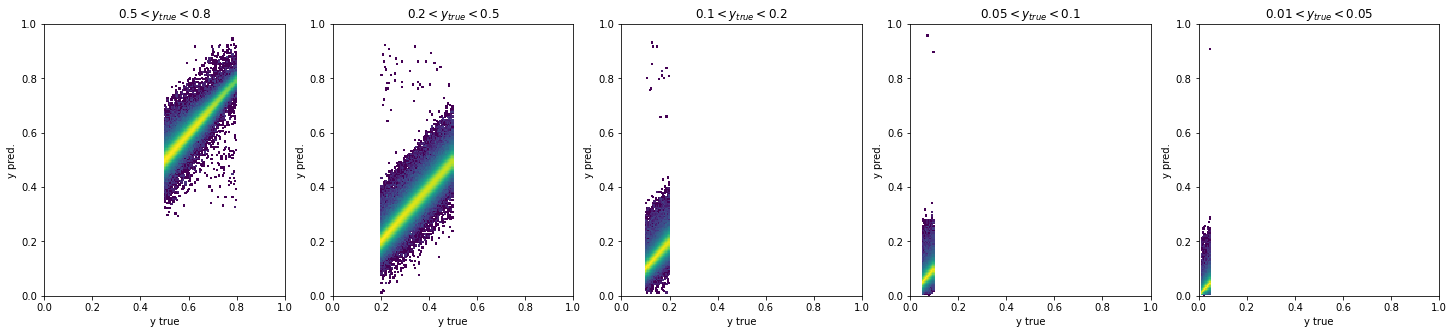

In [83]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

axis_max = 1

ax[0].hist2d( true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('y pred.')
    ax[i].set_xlabel('y true')


    
plt.show()

## Plots of pred/true of physics variable x

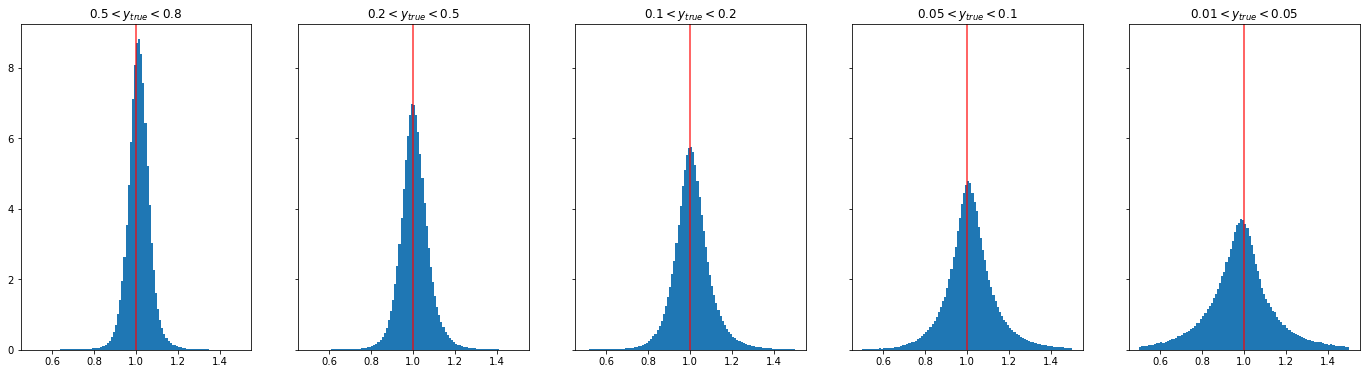

In [84]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Plots of pred/true of physics variable Q2

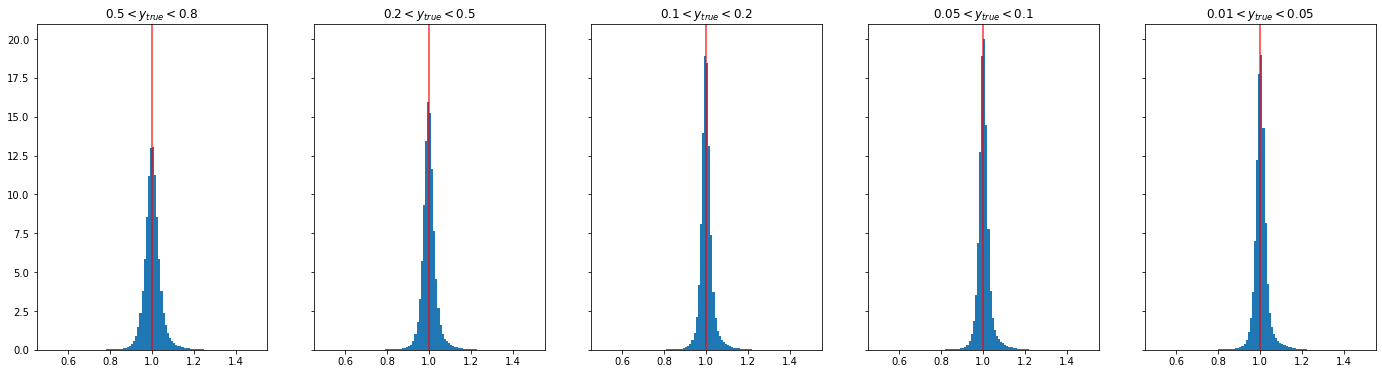

In [85]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Plots of pred/true of physics variable y

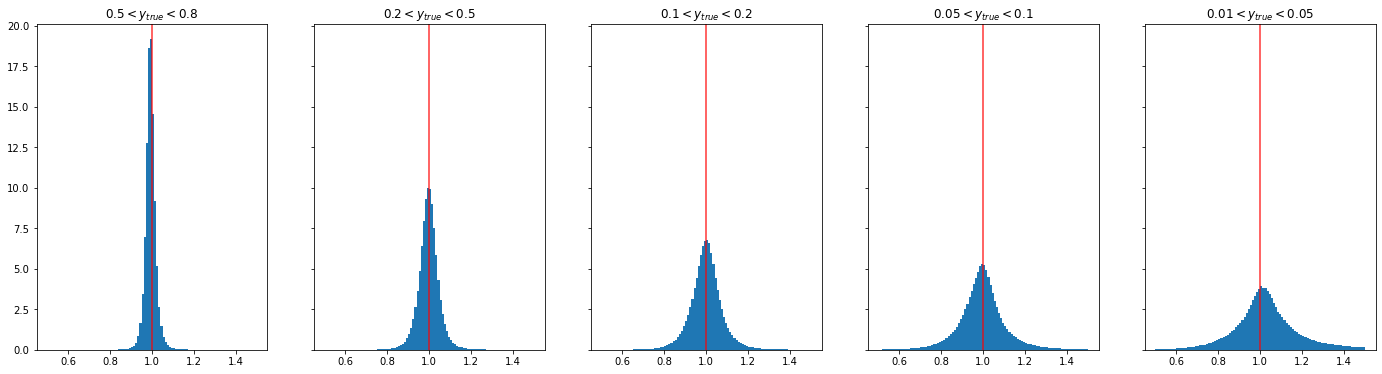

In [86]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Comparison plots of resolution for methods vs DNN


## resolution in x

   0,  0,  5 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0,  5 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0,  5 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0,  5 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0,  5 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1,  4 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1,  4 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1,  4 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1,  4 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1,  4 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2,  3 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2,  3 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2,  3 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2,  3 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  2,  3 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  3,  0 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  3,  0 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.

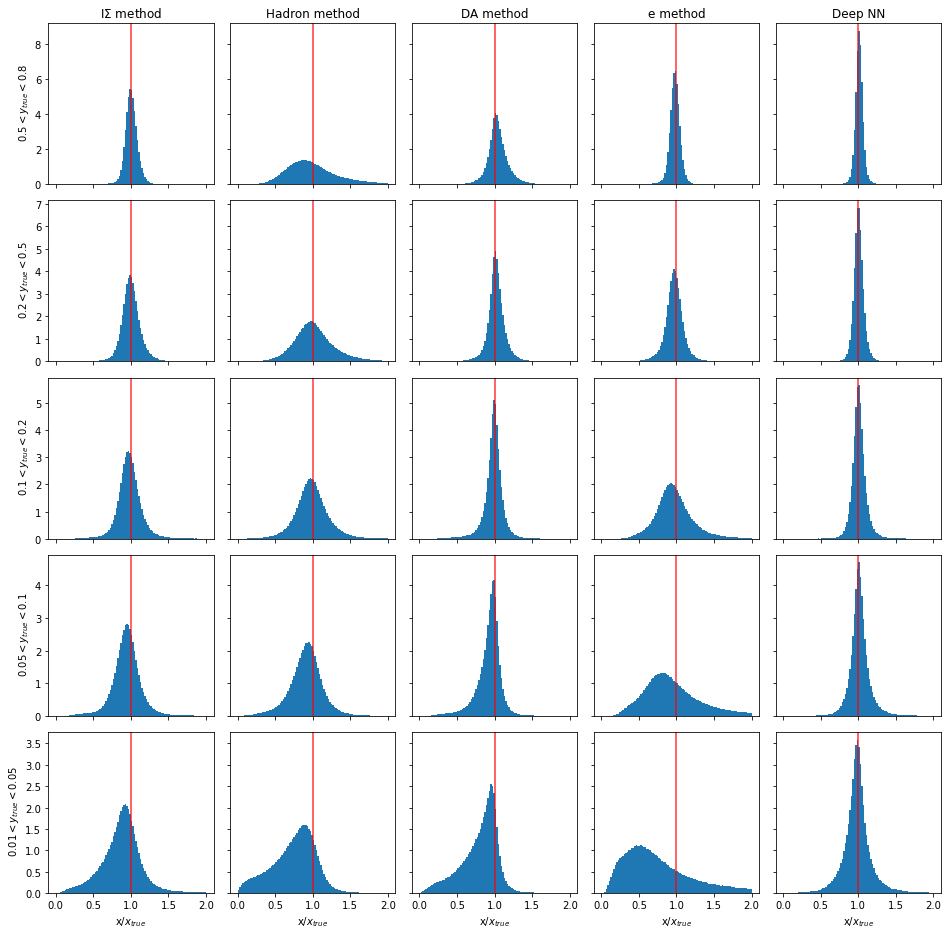

In [87]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

xmin = 0.0
xmax = 2.0

#xmin = 0.5
#xmax = 1.5

y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_x[%d]' % mi ]/pandas_df.query(y_cut[yi])['from_tlv_gen_x'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('x/$x_{true}$')
ax[4][1].set_xlabel('x/$x_{true}$')
ax[4][2].set_xlabel('x/$x_{true}$')
ax[4][3].set_xlabel('x/$x_{true}$')
ax[4][4].set_xlabel('x/$x_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=2,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)


## resolution in Q2

   0,  0,  5 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0,  5 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0,  5 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0,  5 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0,  5 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1,  4 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1,  4 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1,  4 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1,  4 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1,  4 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2,  3 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2,  3 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2,  3 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2,  3 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  2,  3 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  3,  0 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  3,  0 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.

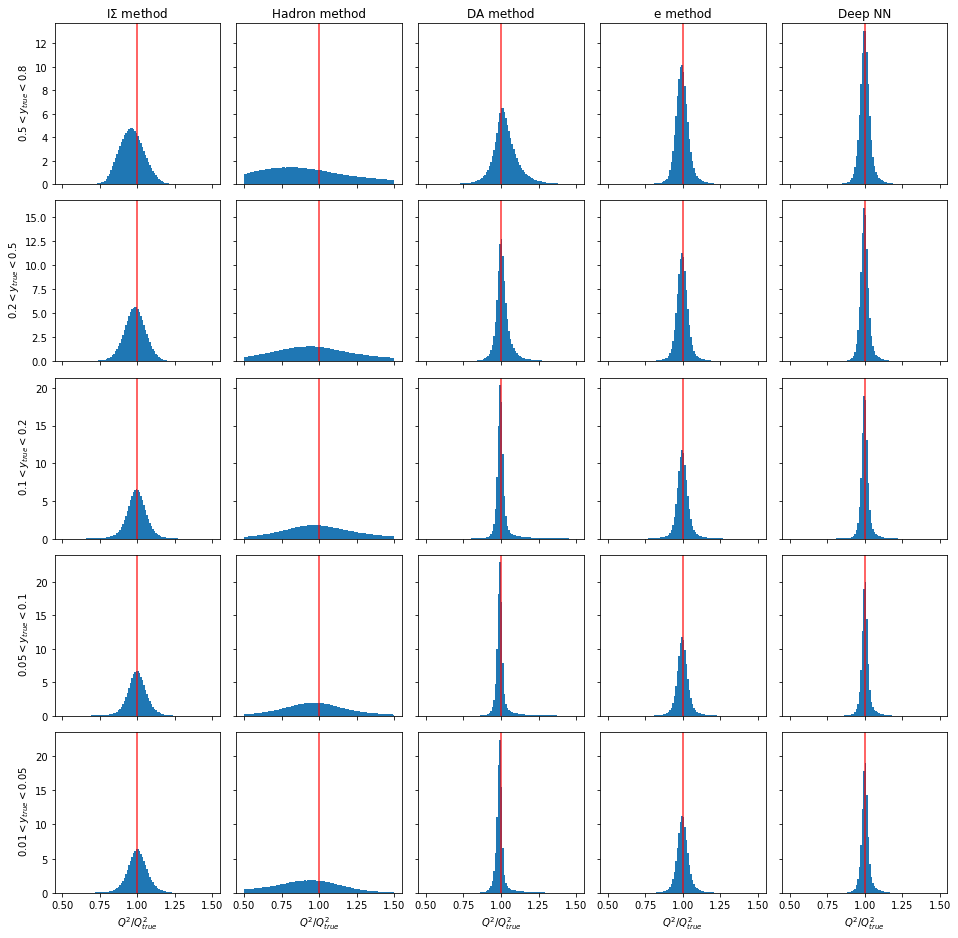

In [88]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

nn_output_index = 1

#xmin = 0.90
#xmax = 1.10

xmin = 0.5
xmax = 1.5

y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_Q2[%d]' % mi ]/pandas_df.query(y_cut[yi])['from_tlv_gen_Q2'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][1].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][2].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][3].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][4].set_xlabel('$Q^2/Q^2_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=2,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Resolution in y

   0,  0,  5 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0,  5 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0,  5 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0,  5 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0,  5 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1,  4 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1,  4 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1,  4 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1,  4 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1,  4 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2,  3 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2,  3 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2,  3 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2,  3 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  2,  3 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  3,  0 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  3,  0 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.

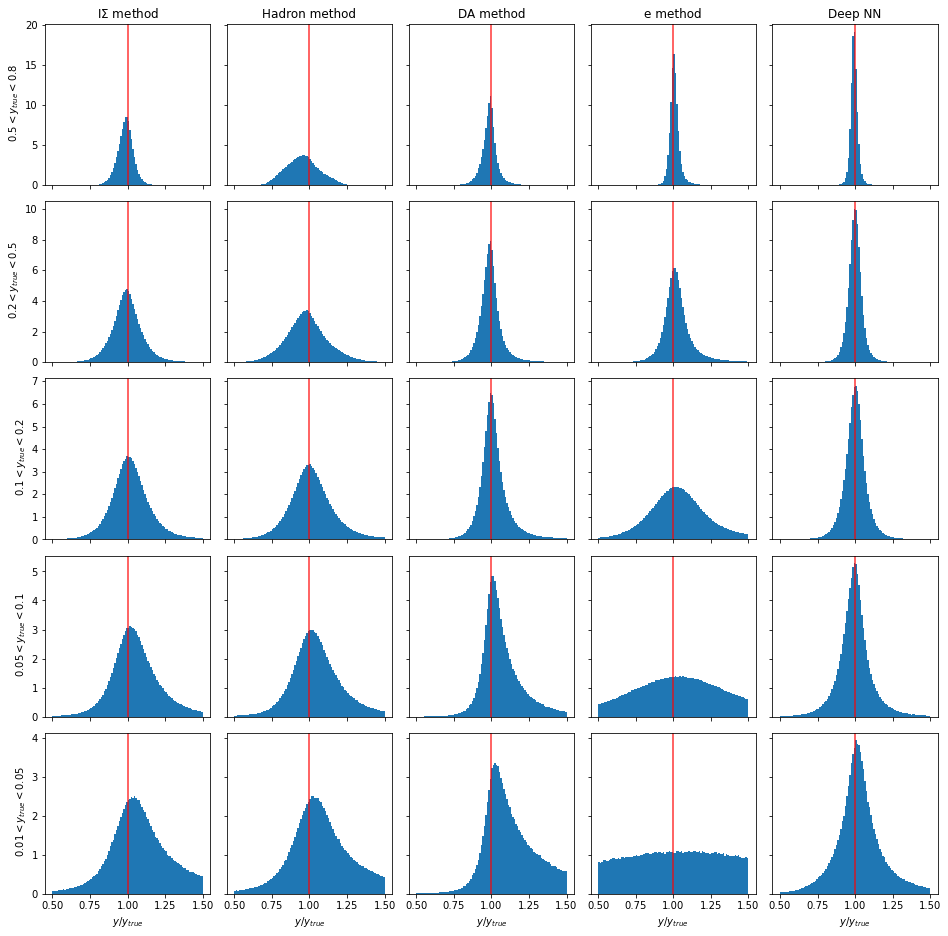

In [89]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

nn_output_index = 2

#xmin = 0.90
#xmax = 1.10

xmin = 0.5
xmax = 1.5

y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_y[%d]' % mi ]/pandas_df.query(y_cut[yi])['from_tlv_gen_y'], 
                       density=True, bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('$y/y_{true}$')
ax[4][1].set_xlabel('$y/y_{true}$')
ax[4][2].set_xlabel('$y/y_{true}$')
ax[4][3].set_xlabel('$y/y_{true}$')
ax[4][4].set_xlabel('$y/y_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=2,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)